In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline as sklearn_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import (KMeans, DBSCAN, MeanShift, SpectralClustering, 
                             AffinityPropagation, AgglomerativeClustering)

In [2]:
sns.set()
%matplotlib inline

In [3]:
RANDOM_STATE = 7532
np.random.seed(RANDOM_STATE)

Utility functions

In [4]:
def missing_data_percentage(df, nan_pct_thrshld=0, show_statistics=True, return_column_names=False):
    
    df_nan_pct = 100 * df.isnull().mean().sort_values(ascending=False)    
    n_cols_above_thrshld = (df_nan_pct > nan_pct_thrshld).sum()
    
    if show_statistics:
        print(f'NaN percentage threshold: {nan_pct_thrshld}%')
        print(f'Number of columns with more than {nan_pct_thrshld}% of missing values: {n_cols_above_thrshld}')
        print()
    
    if n_cols_above_thrshld > 0:        
        tmp_df = pd.DataFrame(df_nan_pct.round(2))
        tmp_df.columns = ['Missing Data %']
        tmp_df.index.name = 'Columns with missing values'
        
        if show_statistics:
            print(tmp_df.head(n_cols_above_thrshld))
        
        if return_column_names:
            return tmp_df.index[df_nan_pct > nan_pct_thrshld].tolist()
    else:
        if return_column_names:
            return []
        
        
def column_group_info(df, group, return_column_names=True):
    
    if group == 'A':
        indx = df.nunique() == 1
    elif group == 'B':
        indx = np.logical_and((df.nunique() >= 2), (df.nunique() < 10))
    elif group == 'C':
        indx = np.logical_and((df.nunique() >= 10), (df.nunique() < 100))
    elif group == 'D':
        indx = np.logical_and((df.nunique() >= 100), (df.nunique() < 1000))
    elif group == 'E':
        indx = df.nunique() >= 1000   
    else:
        raise ValueError("Group has to be one of 'A', 'B', 'C', 'D', 'E'")
    
    columns = df.columns[indx].tolist()
    
    message_1 = f'Number of group {group} columns: {indx.sum()}'
    message_2 = f'Group {group} columns:'
    message_3 = f'Value count for each group {group} column:'

    # number of selected columns
    print(message_1)
    print('-----------------------------------------------------')
    print()

    # names of selected columns
    print(message_2)
    print(columns)
    print('-----------------------------------------------------')
    print()

    # value count for each selected column (including missing values)
    print(message_3)

    for col in columns:
        print(pd.DataFrame(df[col].value_counts(dropna=False)))
        print()
        
    if return_column_names:
        return columns


Load the data

In [5]:
data = pd.read_excel('data/KPMG Data_Spend Analytics 2.xlsx')

Initial glance at the data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75349 entries, 0 to 75348
Data columns (total 65 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Purch.Doc.                           75349 non-null  int64         
 1   Item                                 75349 non-null  int64         
 2   Changed On                           75349 non-null  datetime64[ns]
 3   Short Text                           75349 non-null  object        
 4   Material                             73751 non-null  float64       
 5   CoCd                                 75349 non-null  int64         
 6   Plnt                                 75349 non-null  object        
 7   SLoc                                 62516 non-null  object        
 8   TrackingNo                           4927 non-null   object        
 9   Matl Group                           75349 non-null  object        
 10  PO Quantit

In [7]:
data

,Purch.Doc.,Item,Changed On,Short Text,Material,CoCd,Plnt,SLoc,TrackingNo,Matl Group,...,CRM Item No,Down Payment Amount,Priority (Material Required Within),Ordered By,Approved By,Priority,Section,Indenter ID,Input Tax Credit,Item.2
0,7600174848,10,2019-01-01,IB Ross Broiler Finisher Feed,7101320.0,7860,PS09,F007,NaN,1500,...,0,0,0,0,0,NaN,0,0,NaN,0
1,7600174849,10,2019-01-01,IB Ross Broiler Finisher Feed,7101320.0,7860,PS09,F002,NaN,1500,...,0,0,0,0,0,NaN,0,0,NaN,0
2,7600174850,10,2019-01-01,IB Ross Broiler Finisher Feed,7101320.0,7860,PS09,F010,NaN,1500,...,0,0,0,0,0,NaN,0,0,NaN,0
3,7600174851,10,2019-01-01,IB Ross Broiler Pre-Starter Feed,7101320.0,7860,PS08,T001,NaN,1500,...,0,0,0,0,0,NaN,0,0,NaN,0
4,7600174851,20,2019-01-01,IB Ross Broiler Starter Feed,7101320.0,7860,PS08,T001,NaN,1500,...,0,0,0,0,0,NaN,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75344,9500017212,10,2019-03-28,Hyd. Jack Repair Work Of Bakal Workshop,NaN,7860,1950,NaN,NaN,SERVICE,...,0,0,0,0,0,NaN,0,0,T4,0
75345,9500017213,10,2019-03-28,Turbo Repair Work From New MMG CG08L3078,NaN,7860,1950,NaN,NaN,SERVICE,...,0,0,0,0,0,NaN,0,0,T4,0
75346,9500017214,10,2019-03-28,Turbo Repair Work From New MMG CG08L1458,NaN,7860,1950,NaN,NaN,SERVICE,...,0,0,0,0,0,NaN,0,0,T4,0
75347,9500017215,10,2019-03-28,Hyd.Hose Repair Parmar Auto Indus. L2240,NaN,7860,1950,NaN,NaN,SERVICE,...,0,0,0,0,0,NaN,0,0,T4,0


Duplicate check

In [8]:
if np.any(data.duplicated()):
    print('Data contains duplicates')
else:
    print('Data does not contain duplicates')

Data does not contain duplicates


Missing data percentage per column

In [9]:
missing_data_percentage(data)

NaN percentage threshold: 0%
Number of columns with more than 0% of missing values: 18

                             Mising Data %
Columns with missing values               
S.1                                  99.19
Spec. Stk Valuation                  97.27
S                                    97.27
Cns                                  95.14
A                                    95.14
TrackingNo                           93.46
Requested By                         91.84
Priority                             80.56
Input Tax Credit                     79.29
Un                                   59.96
SLoc                                 17.03
DCI                                  10.29
NCM Code                              2.56
Profit Ctr                            2.12
MTyp                                  2.12
BUn                                   2.12
Material                              2.12
Price Date                            0.37


Columns with a lot of missing data (almost 60% or more) - most likely they will not be very useful.

In [10]:
columns_to_drop = missing_data_percentage(data, 59, False, True)
print(columns_to_drop)

['S.1', 'Spec. Stk Valuation', 'S', 'Cns', 'A', 'TrackingNo', 'Requested By', 'Priority', 'Input Tax Credit', 'Un']


Number of columns with a particular value

In [11]:
indx = data.nunique().sort_values().value_counts().index.tolist()
indx.sort()
df = pd.DataFrame(data.nunique().sort_values().value_counts()[indx])
df.columns = ['Number of Columns']
df.index.name = 'Number of Column Values'
df

,Number of Columns
Number of Column Values,
1,20
2,3
3,1
5,2
6,3
9,1
15,2
17,2
20,1


For convenience, we divide the columns into several categories depending on how many values they have. To this end, we define group A, B, C, D, and E columns as follows:
- Group A: Columns with a single value
- Group B: Columns with at least 2 and less than 10 values
- Group C: Columns with at least 10 and less than 100 values
- Group D: Columns with at least 100 and less than 1000 values
- Group E: Columns with at least 1000 values

Below, we present some insights into the group A columns. Most of these columns being constant are of no value, however, we suspect that the missing values that are present in some of these columns indicate lack of certain quality and hence such columns can be turned into variables with only two values 0 or 1. Nevertheless, we are not going to need them.

In [12]:
selected_columns = column_group_info(data, 'A')

Number of group A columns: 20
-----------------------------------------------------

Group A columns:
['Conv.', 'GRT', 'DCI', 'Agr. Cum. Qty', 'TOZ', 'Quantity', 'Cat', 'S', 'Net value', 'S.1', 'Object no.', 'Time of Transmission', 'Next Transmission Number', 'Itm', 'Spec. Stk Valuation', 'Itm.1', 'Requirement Urgency', 'CRM  Item No', 'Down Payment Amount', 'Item.2']
-----------------------------------------------------

Value count for each group A column:
   Conv.
1  75349

     GRT
0  75349

       DCI
X    67599
NaN   7750

   Agr. Cum. Qty
0          75349

     TOZ
0  75349

   Quantity
0     75349

     Cat
F  75349

         S
NaN  73289
Q     2060

   Net value
0      75349

       S.1
NaN  74740
X      609

   Object no.
0       75349

            Time of Transmission
1899-12-30                 75349

   Next Transmission Number
1                     75349

     Itm
0  75349

     Spec. Stk Valuation
NaN                73292
M                   2057

   Itm.1
0  75349

   Re

Update columns to drop

In [13]:
columns_to_drop.extend(selected_columns)
columns_to_drop = list(set(columns_to_drop))
print(columns_to_drop)

['Agr. Cum. Qty', 'Cat', 'Priority', 'Spec. Stk Valuation', 'Requested By', 'Object no.', 'Next Transmission Number', 'Cns', 'A', 'DCI', 'Down Payment Amount', 'Quantity', 'Requirement Urgency', 'S.1', 'Item.2', 'CRM  Item No', 'S', 'Time of Transmission', 'Itm.1', 'Itm', 'GRT', 'Un', 'Net value', 'Input Tax Credit', 'TOZ', 'Conv.', 'TrackingNo']


Below, we present some insights into the group B columns. we are going to keep the **CoCd** column only as other columns are almost constant or have too many missing values.

In [14]:
selected_columns = column_group_info(data, 'B')

Number of group B columns: 10
-----------------------------------------------------

Group B columns:
['CoCd', 'Eq. To', 'Underdel.Tol.', 'A', 'Cns', 'PTm', 'Un', 'Volume', 'Priority', 'Input Tax Credit']
-----------------------------------------------------

Value count for each group B column:
       CoCd
9000  43589
7860  29527
7000   1121
4500   1066
8000     46

   Eq. To
1   73751
0    1598

    Underdel.Tol.
0           74869
5             424
30             18
1              17
10             16
2               5

         A
NaN  71686
Q     2060
F      707
K      560
P      324
A       12

       Cns
NaN  71686
P     2060
V     1591
A       12

       PTm
0    75192
100    157

        Un
NaN  45183
KG   24901
TO    5265

       Volume
0.00    75322
0.97       16
1.00        5
20.00       3
5.00        2
0.50        1

           Priority
NaN           60698
Medium         7121
High           2692
Low            2424
Very High      2307
MEDIUM           41
MEDIAM           36


Update columns to drop

In [15]:
columns_to_drop.extend(selected_columns)
columns_to_drop = list(set(columns_to_drop) - set(['CoCd']))
print(columns_to_drop)

['Agr. Cum. Qty', 'Cat', 'Priority', 'Spec. Stk Valuation', 'Requested By', 'Object no.', 'Next Transmission Number', 'Cns', 'A', 'DCI', 'Down Payment Amount', 'Quantity', 'Requirement Urgency', 'Volume', 'S.1', 'PTm', 'Item.2', 'CRM  Item No', 'S', 'Underdel.Tol.', 'Time of Transmission', 'Itm.1', 'Itm', 'Eq. To', 'GRT', 'Un', 'Net value', 'Input Tax Credit', 'TOZ', 'Conv.', 'TrackingNo']


Below, we present some insights into the group C columns. We remove weight and unit information, almost constant columns, and ID columns with many missing values. Columns such as **Per**, **Overdel. Tol.**, **RShLi**, **MType**, **Priority (Material Required Within)** could be useful, however, we are not going to need them.

In [16]:
selected_columns = column_group_info(data, 'C')

Number of group C columns: 15
-----------------------------------------------------

Group C columns:
['Item', 'OUn', 'OPU', 'Per', 'Overdel. Tol.', 'Item.1', 'BUn', 'Effective value', 'Net Weight', 'Gross Weight', 'RShLi', 'MTyp', 'Priority (Material Required Within)', 'Approved By', 'Indenter ID']
-----------------------------------------------------

Value count for each group C column:
      Item
10   42576
20   23362
30    5317
40    1141
50     734
60     514
70     359
80     249
90     183
100    143
110    111
120     93
130     79
140     65
150     62
160     52
170     42
180     39
190     31
200     27
210     24
220     22
230     20
240     16
250     14
260     11
280      9
270      9
290      8
300      5
340      5
310      5
350      4
330      4
320      3
370      2
390      2
360      2
380      2
400      1
1        1
410      1

       OUn
KG   37700
EA   21895
TO    9643
L     1823
DOS   1526
LE    1343
M      358
SET    255
FT2    174
PAK    171
VIL    118
P

Update columns to drop

In [17]:
columns_to_drop.extend(selected_columns)
columns_to_drop = list(set(columns_to_drop))
print(columns_to_drop)

['Agr. Cum. Qty', 'Cat', 'Effective value', 'Priority', 'Spec. Stk Valuation', 'Requested By', 'Object no.', 'Priority (Material Required Within)', 'OUn', 'Item.1', 'Next Transmission Number', 'Approved By', 'Cns', 'OPU', 'A', 'DCI', 'Down Payment Amount', 'BUn', 'Quantity', 'Requirement Urgency', 'Volume', 'S.1', 'PTm', 'Item.2', 'MTyp', 'Overdel. Tol.', 'Per', 'CRM  Item No', 'S', 'Underdel.Tol.', 'Time of Transmission', 'Itm.1', 'Itm', 'Eq. To', 'Gross Weight', 'RShLi', 'GRT', 'Net Weight', 'Un', 'Item', 'Net value', 'Input Tax Credit', 'TOZ', 'Conv.', 'Indenter ID', 'TrackingNo']


Below, we present some insights into the group D columns. Here, we keep the **Plnt**, **'Matl Group**, and **Price Date** columns.

In [18]:
selected_columns = column_group_info(data, 'D')

Number of group D columns: 10
-----------------------------------------------------

Group D columns:
['Changed On', 'Plnt', 'TrackingNo', 'Matl Group', 'Price Date', 'Profit Ctr', 'NCM Code', 'Requested By', 'Ordered By', 'Section']
-----------------------------------------------------

Value count for each group D column:
            Changed On
2019-01-08        1867
2019-02-25        1577
2019-01-14        1555
2019-03-18        1439
2019-03-19        1438
...                ...
2012-07-16           1
2018-08-29           1
2018-10-05           1
2017-12-09           1
2018-04-20           1

[210 rows x 1 columns]

       Plnt
9120  12575
9150   9483
9401   8526
1950   2559
1110   2356
...     ...
1704      1
1334      1
9015      1
1530      1
1754      1

[116 rows x 1 columns]

            TrackingNo
NaN              70422
9110               734
4510               567
1110               301
9108               213
...                ...
393                  1
1913                

Update columns to drop

In [19]:
columns_to_drop.extend(selected_columns)
columns_to_drop = list(set(columns_to_drop) - set(['Plnt', 'Matl Group', 'Price Date']))
print(columns_to_drop)

['Agr. Cum. Qty', 'Cat', 'Effective value', 'Priority', 'Spec. Stk Valuation', 'Requested By', 'Profit Ctr', 'Object no.', 'Changed On', 'Priority (Material Required Within)', 'OUn', 'Item.1', 'Approved By', 'Next Transmission Number', 'Cns', 'OPU', 'A', 'DCI', 'Down Payment Amount', 'BUn', 'Quantity', 'Requirement Urgency', 'Volume', 'Ordered By', 'S.1', 'PTm', 'Item.2', 'MTyp', 'Overdel. Tol.', 'Per', 'CRM  Item No', 'S', 'Underdel.Tol.', 'Time of Transmission', 'Itm.1', 'Itm', 'Eq. To', 'Gross Weight', 'RShLi', 'GRT', 'Net Weight', 'Section', 'Un', 'Item', 'Net value', 'Input Tax Credit', 'TOZ', 'NCM Code', 'Conv.', 'Indenter ID', 'TrackingNo']


Below, we present some insights into the group E columns. Here, we keep the following columns: **Short Text**, **Material**, **SLoc**, **PO Quantity**, **Net Price**, **Net Value**, **Gross value**.

In [20]:
selected_columns = column_group_info(data, 'E')

Number of group E columns: 10
-----------------------------------------------------

Group E columns:
['Purch.Doc.', 'Short Text', 'Material', 'SLoc', 'PO Quantity', 'Net Price', 'Net Value', 'Gross value', 'Non-deductible', 'Reb.basis']
-----------------------------------------------------

Value count for each group E column:
            Purch.Doc.
1000007903          39
1000007705          37
1000007862          35
1000007659          34
2000013320          33
...                ...
7600177773           1
9100311146           1
9100307048           1
7000015461           1
9100315603           1

[42596 rows x 1 columns]

                                      Short Text
IB Ross Broiler Finisher Feed               7864
IB Ross Broiler Starter Feed                6965
Gunny-Bags Damage-Pp-0.3Kg                  6013
Gunny-Bags Damage-2 Katta-0.7Kg             5295
IB Ross Broiler Pre-Starter Feed            5280
...                                          ...
Ms Nipple 1.5"X6"       

Update columns to drop

In [21]:
columns_to_drop.extend(selected_columns)
columns_to_drop = list(set(columns_to_drop) - set(['Short Text', 'Material', 'SLoc', 'PO Quantity', 'Net Price', 'Net Value', 'Gross value']))
print(columns_to_drop)

['Agr. Cum. Qty', 'Cat', 'Effective value', 'Priority', 'Spec. Stk Valuation', 'Requested By', 'Profit Ctr', 'Reb.basis', 'Object no.', 'Changed On', 'Priority (Material Required Within)', 'OUn', 'Item.1', 'Next Transmission Number', 'Approved By', 'Cns', 'Purch.Doc.', 'OPU', 'A', 'DCI', 'Down Payment Amount', 'BUn', 'Quantity', 'Requirement Urgency', 'Volume', 'Ordered By', 'S.1', 'PTm', 'Item.2', 'Non-deductible', 'MTyp', 'Overdel. Tol.', 'Per', 'CRM  Item No', 'S', 'Underdel.Tol.', 'Time of Transmission', 'Itm.1', 'Itm', 'Eq. To', 'Gross Weight', 'RShLi', 'GRT', 'Net Weight', 'Section', 'Un', 'Item', 'Net value', 'Input Tax Credit', 'TOZ', 'NCM Code', 'Conv.', 'Indenter ID', 'TrackingNo']


Remaining columns

In [22]:
print(list(set(data.columns) - set(columns_to_drop)))

['Plnt', 'Net Value', 'Net Price', 'Material', 'Short Text', 'Price Date', 'Matl Group', 'PO Quantity', 'Gross value', 'SLoc', 'CoCd']


Given the above list we reorder these columns and select a subset of data to work with

In [23]:
column_selection = [
    'CoCd', 'Material', 'Short Text', 'Plnt', 'SLoc', 'Matl Group', 
    'PO Quantity', 'Net Price', 'Net Value', 'Gross value', 'Price Date'
]

data_1 = data.loc[:, column_selection].copy()

A quick look at **data_1** dataframe

In [24]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75349 entries, 0 to 75348
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CoCd         75349 non-null  int64         
 1   Material     73751 non-null  float64       
 2   Short Text   75349 non-null  object        
 3   Plnt         75349 non-null  object        
 4   SLoc         62516 non-null  object        
 5   Matl Group   75349 non-null  object        
 6   PO Quantity  75349 non-null  float64       
 7   Net Price    75349 non-null  float64       
 8   Net Value    75349 non-null  float64       
 9   Gross value  75349 non-null  float64       
 10  Price Date   75068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 6.3+ MB


In [25]:
data_1

,CoCd,Material,Short Text,Plnt,SLoc,Matl Group,PO Quantity,Net Price,Net Value,Gross value,Price Date
0,7860,7101320.0,IB Ross Broiler Finisher Feed,PS09,F007,1500,23000.0,27.82,639860.0,639860.0,2018-12-27
1,7860,7101320.0,IB Ross Broiler Finisher Feed,PS09,F002,1500,18000.0,27.82,500760.0,500760.0,2018-12-27
2,7860,7101320.0,IB Ross Broiler Finisher Feed,PS09,F010,1500,19000.0,27.82,528580.0,528580.0,2018-12-27
3,7860,7101320.0,IB Ross Broiler Pre-Starter Feed,PS08,T001,1500,15000.0,29.36,440400.0,440400.0,2018-12-28
4,7860,7101320.0,IB Ross Broiler Starter Feed,PS08,T001,1500,7000.0,28.20,197400.0,197400.0,2018-12-28
...,...,...,...,...,...,...,...,...,...,...,...
75344,7860,NaN,Hyd. Jack Repair Work Of Bakal Workshop,1950,NaN,SERVICE,1.0,1500.00,1500.0,1500.0,2019-03-28
75345,7860,NaN,Turbo Repair Work From New MMG CG08L3078,1950,NaN,SERVICE,1.0,4050.00,4050.0,4050.0,2019-03-28
75346,7860,NaN,Turbo Repair Work From New MMG CG08L1458,1950,NaN,SERVICE,1.0,2100.00,2100.0,2100.0,2019-03-28
75347,7860,NaN,Hyd.Hose Repair Parmar Auto Indus. L2240,1950,NaN,SERVICE,1.0,450.00,450.0,450.0,2019-03-28


In [26]:
missing_data_percentage(data_1)

NaN percentage threshold: 0%
Number of columns with more than 0% of missing values: 3

                             Mising Data %
Columns with missing values               
SLoc                                 17.03
Material                              2.12
Price Date                            0.37


We can restrict our attention to the most recent data available, i.e., to the year 2019 as we retain almost 90% of all the records and over 93% of total spending.

In [27]:
n_records = data_1.shape[0]
n_records_2019 = data_1.loc[data_1['Price Date'] >= pd.to_datetime('2019'), :].shape[0]

total_spending = data_1['Gross value'].sum()
spending_2019 = data_1.loc[data_1['Price Date'] >= pd.to_datetime('2019'), 'Gross value'].sum()

print(f'Percentage of retained records for 2019: {np.round(100 * (n_records_2019 / n_records), 3)}%')
print(f'Percentage of total spending generated in 2019 only: {np.round(100 * (spending_2019 / total_spending), 3)}%')


Percentage of retained records for 2019: 89.573%
Percentage of total spending generated in 2019 only: 93.416%


In [28]:
data_1 = data_1.loc[data_1['Price Date'] >= pd.to_datetime('2019'), :]
data_1

,CoCd,Material,Short Text,Plnt,SLoc,Matl Group,PO Quantity,Net Price,Net Value,Gross value,Price Date
328,7860,7101310.0,IB Ross Breeder Grower,PP29,A001,1500,25970.0,26.58,690282.6,690282.6,2019-01-01
361,7860,7101320.0,IB Ross Broiler Pre-Starter Feed,PS18,F004,1500,5000.0,31.48,157400.0,157400.0,2019-01-01
362,7860,7101320.0,IB Ross Broiler Finisher Feed,PS18,F004,1500,10000.0,29.18,291800.0,291800.0,2019-01-01
363,7860,7101320.0,IB Ross Broiler Starter Feed,PS18,F004,1500,10000.0,30.14,301400.0,301400.0,2019-01-01
364,7860,7101320.0,IB Ross Broiler Pre-Starter Feed,PS18,F004,1500,4000.0,31.48,125920.0,125920.0,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...
75344,7860,NaN,Hyd. Jack Repair Work Of Bakal Workshop,1950,NaN,SERVICE,1.0,1500.00,1500.0,1500.0,2019-03-28
75345,7860,NaN,Turbo Repair Work From New MMG CG08L3078,1950,NaN,SERVICE,1.0,4050.00,4050.0,4050.0,2019-03-28
75346,7860,NaN,Turbo Repair Work From New MMG CG08L1458,1950,NaN,SERVICE,1.0,2100.00,2100.0,2100.0,2019-03-28
75347,7860,NaN,Hyd.Hose Repair Parmar Auto Indus. L2240,1950,NaN,SERVICE,1.0,450.00,450.0,450.0,2019-03-28


In [29]:
missing_data_percentage(data_1)

NaN percentage threshold: 0%
Number of columns with more than 0% of missing values: 2

                             Mising Data %
Columns with missing values               
SLoc                                 15.82
Material                              1.85


A potential problem with missing values in SLoc (storage location) - only about half of the spend is accounted for. We will see in due course that this issue will not be significant enough to impact our analysis.

In [30]:
grouped_data = data_1.groupby(['SLoc', 'CoCd', 'Material', 'Short Text']).sum()['Gross value'].sort_values(ascending=False) / data_1['Gross value'].sum()
grouped_data.cumsum()

SLoc  CoCd  Material   Short Text                     
9101  9000  910970.0   Soya Bean - (MP)                   0.042242
            910070.0   Soya Bean - (A)                    0.079732
            910000.0   Soya Bean                          0.097162
F001  7860  7101320.0  IB Ross Broiler Finisher Feed      0.113856
F003  7860  7101320.0  IB Ross Broiler Finisher Feed      0.125731
                                                            ...   
9409  9000  950020.0   Gunny-Bags Damage-2 Katta-0.7Kg    0.481437
                       Gunny Bags-Pp-0.3Kg                0.481437
9403  9000  950020.0   Gunny-Bags Damage-Pp-0.3Kg         0.481437
CGEN  9000  7400000.0  LPG Cylinder 35 Kg                 0.481437
9403  9000  950020.0   Gunny-Bags Damage-2 Katta-0.7Kg    0.481437
Name: Gross value, Length: 8688, dtype: float64

In a handful of cases the same spending description corresponds to two different material codes

In [31]:
tmp_spending = 0

for description in data_1['Short Text'].value_counts().index:
    if data_1.loc[data_1['Short Text'] == description, 'Material'].nunique() > 1:
        tmp_spending += data_1.loc[data_1['Short Text'] == description, 'Gross value'].sum()
        print(description)
        print(data_1.loc[data_1['Short Text'] == description, 'Material'].value_counts())
        print()
        
print(f'Percentage of spending for such cases: {tmp_spending / total_spending}')

Potato
910530.0    20
801980.0    11
Name: Material, dtype: int64

Onion
910530.0    22
801980.0     7
Name: Material, dtype: int64

Mono Calsium phosphat (MCP)
910100.0     22
7101810.0     4
Name: Material, dtype: int64

Red Capsicum
910840.0    9
814770.0    1
Name: Material, dtype: int64

M Seal
801000.0     4
7701150.0    3
Name: Material, dtype: int64

Maxtreat 9002
940000.0     4
7400700.0    1
Name: Material, dtype: int64

Copper Sulphate
7100100.0    4
920140.0     1
Name: Material, dtype: int64

Bearing 6203 2RS
812340.0     3
7703020.0    1
Name: Material, dtype: int64

PP Bag Broiler Starter (50Kg)
7300600.0    3
951500.0     1
Name: Material, dtype: int64

Milk Made (Cream)
816000.0    2
910590.0    1
Name: Material, dtype: int64

Dettol Bandage
7100300.0    1
818490.0     1
Name: Material, dtype: int64

Betadin Tube
818500.0     1
7100300.0    1
Name: Material, dtype: int64

Chocolate Syrup
816490.0    1
910690.0    1
Name: Material, dtype: int64

Doxycycline
920440.0    

However, in the vast majority of cases material can be subdivided with respect to its description (short text) and we can see that when we perform the aggregation with respect to the **company code**, **material** and **short text** we still retain over **93%** of total spending despite some interference from missing values.

In [32]:
grouped_data = data_1.groupby(['CoCd', 'Material', 'Short Text']).sum()['Gross value']
grouped_data = grouped_data.sort_values(ascending=False) / total_spending
grouped_data.cumsum()

CoCd  Material   Short Text                     
7860  7101320.0  IB Ross Broiler Finisher Feed      0.099324
                 IB Ross Broiler Starter Feed       0.172742
9000  910970.0   Soya Bean - (MP)                   0.221110
7860  7101330.0  B4 IB Ross Feed                    0.265036
9000  910070.0   Soya Bean - (A)                    0.304566
                                                      ...   
7860  7200250.0  Layer Live Bird No                 0.931295
      7200260.0  Breeder Live Bird No               0.931295
      7201340.0  IB AP95 Broiler Live Bird_BB No    0.931295
      7400000.0  LPG Cylinder 35 Kg                 0.931295
      7400010.0  LPG Cylinder 14 kg                 0.931295
Name: Gross value, Length: 5865, dtype: float64

Below, we select the minimal number of combinations of the **company code**, **material** and **short text** so that when combined together they carry at least **93%** of total spending. It turns out that there are **1126** such combinations.

In [33]:
n_combinations = 1126
grouped_data.cumsum().head(n_combinations)

CoCd  Material   Short Text                     
7860  7101320.0  IB Ross Broiler Finisher Feed      0.099324
                 IB Ross Broiler Starter Feed       0.172742
9000  910970.0   Soya Bean - (MP)                   0.221110
7860  7101330.0  B4 IB Ross Feed                    0.265036
9000  910070.0   Soya Bean - (A)                    0.304566
                                                      ...   
4500  819240.0   Rotary Hammer                      0.929993
9000  980250.0   Tesioning Element                  0.929995
      964930.0   Numex Batch Coder                  0.929996
7860  807330.0   Cement Sheet 2.5 Mtr               0.929998
9000  802310.0   MS Angle 65X65X6, 5.80 kg / mtr    0.930000
Name: Gross value, Length: 1126, dtype: float64

### Now, we are going to use clustering to select potential savings opportunities

Data preparation

In [34]:
%%time

n_unique_days_per_combination = []
n_purchases_per_combination = []

for (company_code, material, description) in grouped_data.index[:n_combinations]: 
    
    # Select data with the right company_code, material, and description
    indx_cocd = (data_1['CoCd'] == company_code).values
    indx_text = (data_1['Short Text'] == description).values
    indx_material = (data_1['Material'] == material).values
    indx = indx_cocd * indx_text * indx_material 
    data_2 = data_1.loc[indx, :]
    
    # Calculate frequency and number of days of spending
    n_purchases = data_2['Price Date'].count()
    n_purchases_per_combination.append(n_purchases)
    n_unique_days = data_2['Price Date'].nunique()
    n_unique_days_per_combination.append(n_unique_days)
        
n_unique_days_per_combination = np.array(n_unique_days_per_combination)
n_purchases_per_combination = np.array(n_purchases_per_combination)

Wall time: 7.14 s


In [35]:
df = pd.DataFrame(grouped_data[grouped_data.index[:n_combinations]])
df.columns = ['Total Gross Value %']
df['Spending Frequency'] = n_purchases_per_combination[:n_combinations]
# For reference only
df['Spending Days'] = n_unique_days_per_combination[:n_combinations]

df

Total Gross Value %  \
CoCd Material  Short Text                                             
7860 7101320.0 IB Ross Broiler Finisher Feed               0.099324   
               IB Ross Broiler Starter Feed                0.073418   
9000 910970.0  Soya Bean - (MP)                            0.048367   
7860 7101330.0 B4 IB Ross Feed                             0.043926   
9000 910070.0  Soya Bean - (A)                             0.039531   
...                                                             ...   
4500 819240.0  Rotary Hammer                               0.000002   
9000 980250.0  Tesioning Element                           0.000002   
     964930.0  Numex Batch Coder                           0.000002   
7860 807330.0  Cement Sheet 2.5 Mtr                        0.000002   
9000 802310.0  MS Angle 65X65X6, 5.80 kg / mtr             0.000002   

                                                Spending Frequency  \
CoCd Material  Short Text                                            
7860 7101320.0 IB Ross Broiler Finisher Feed                  7547   
               IB Ross Broiler Starter Feed                   6726   
9000 910970.0  Soya Bean - (MP)                               2468   
7860 7101330.0 B4 IB Ross Feed                                  34   
9000 910070.0  Soya Bean - (A)                                1934   
...                                                            ...   
4500 819240.0  Rotary Hammer                                     2   
9000 980250.0  Tesioning Element                                 1   
     964930.0  Numex Batch Coder                                 3   
7860 807330.0  Cement Sheet 2.5 Mtr                              1   
9000 802310.0  MS Angle 65X65X6, 5.80 kg / mtr                   3   

                                                Spending Days  
CoCd Material  Short Text                                      
7860 7101320.0 IB Ross Broiler Finisher Feed               89  
               IB Ross Broiler Starter Feed                89  
9000 910970.0  Soya Bean - (MP)                            88  
7860 7101330.0 B4 IB Ross Feed                              5  
9000 910070.0  Soya Bean - (A)                             87  
...                                                       ...  
4500 819240.0  Rotary Hammer                                2  
9000 980250.0  Tesioning Element                            1  
     964930.0  Numex Batch Coder                            2  
7860 807330.0  Cement Sheet 2.5 Mtr                         1  
9000 802310.0  MS Angle 65X65X6, 5.80 kg / mtr              3  

[1126 rows x 3 columns]

Correlation among the columns

In [36]:
df.corr()

,Total Gross Value %,Spending Frequency,Spending Days
Total Gross Value %,1.000000,0.750459,0.434253
Spending Frequency,0.750459,1.000000,0.598360
Spending Days,0.434253,0.598360,1.000000


Final data selection for clustering (exclude **Spending Days** )

In [37]:
df_cluster = df.loc[:, ['Total Gross Value %', 'Spending Frequency']]

Technical prepration

In [38]:
col_1 = 'Spending Days'
col_2 = 'Spending Frequency'
col_3 = 'Total Gross Value %'
col_4 = 'Cluster'

color_palette = ['#C44E52', '#55A868']

**KMeans** - not ideal (requires manual cluster merging), as reflected by the clustering results, since in our case there is a huge concentration of points with relatively low value and low frequency and only a handful of points with relatively high value and high frequency. The number of clusters suggested by the elbow method (see beow) appears to be 4, however, a better choice, more in line with a business intuition, seems to be 6 (where some clusters can be merged).

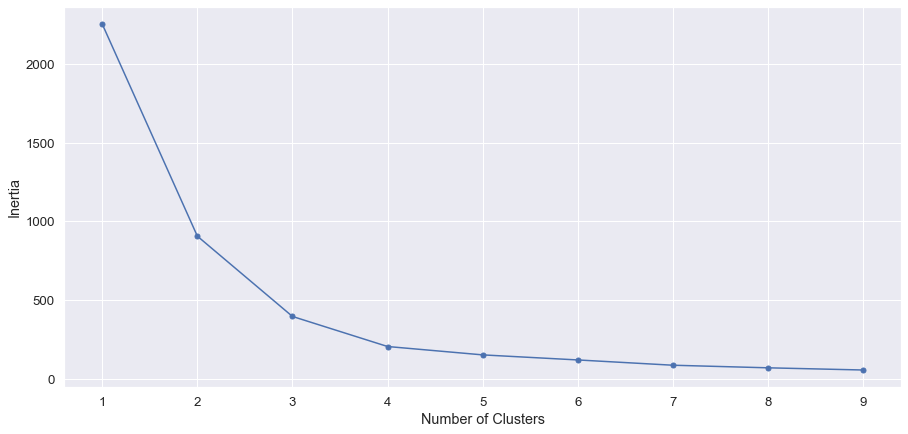

Wall time: 1.45 s


In [39]:
%%time

n_clusters_range = list(range(1, 10))
inertia = []
df_dict = dict()

for n_clusters in n_clusters_range:  
    
    model = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    pipeline = sklearn_pipeline([
        ('std_scaler', StandardScaler()),
        ('model', model)    
    ])
    pipeline.fit(df_cluster)
    
    inertia.append(pipeline['model'].inertia_)
    
    df_dict[n_clusters] = df_cluster.copy()
    df_dict[n_clusters]['Cluster'] = pipeline['model'].labels_ + 1

with sns.plotting_context('notebook', font_scale=1.2):
    plt.figure(figsize=(15, 7))
    plt.plot(n_clusters_range, inertia, marker='.', markersize=10)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

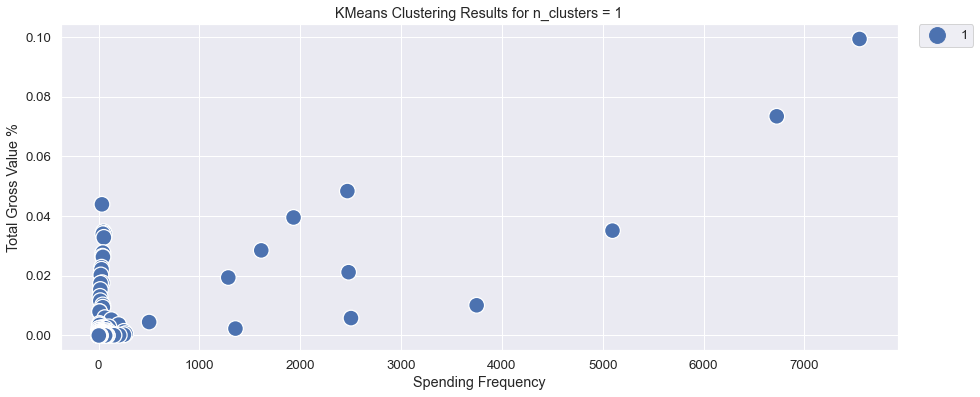

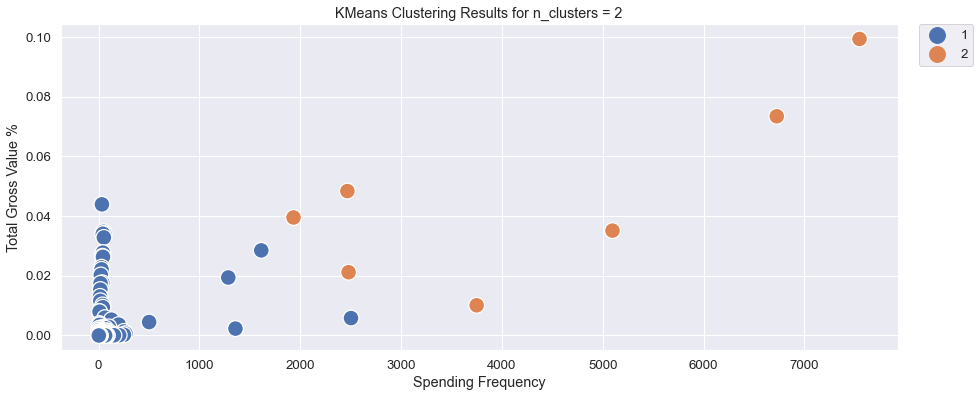

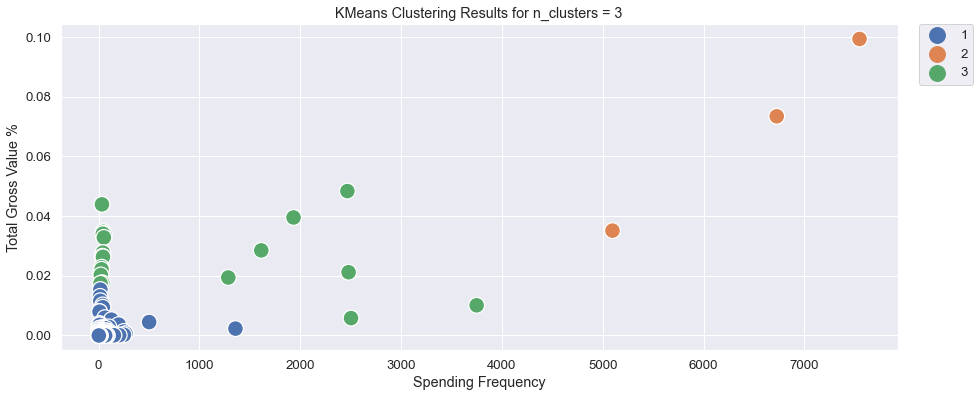

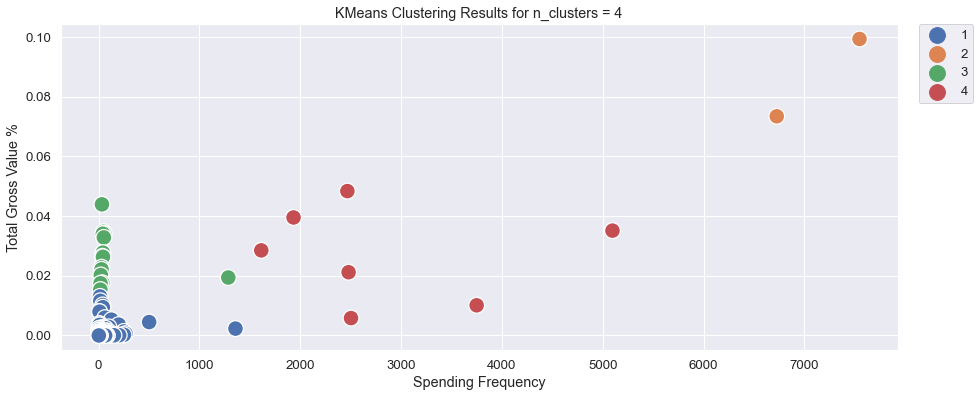

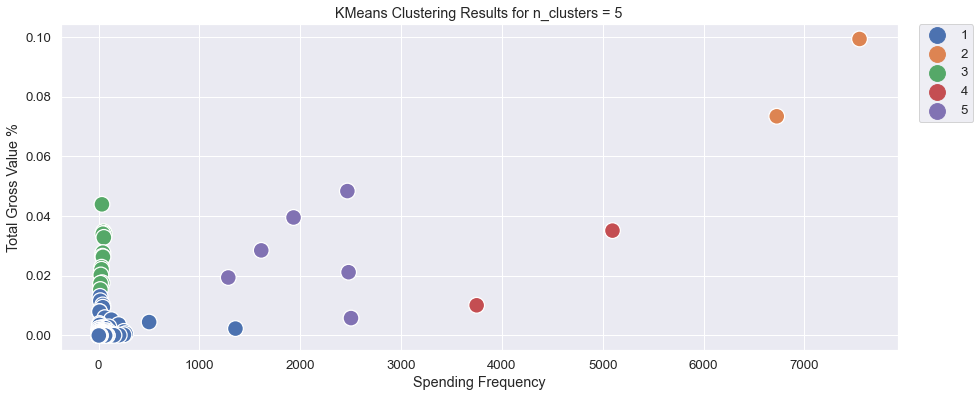

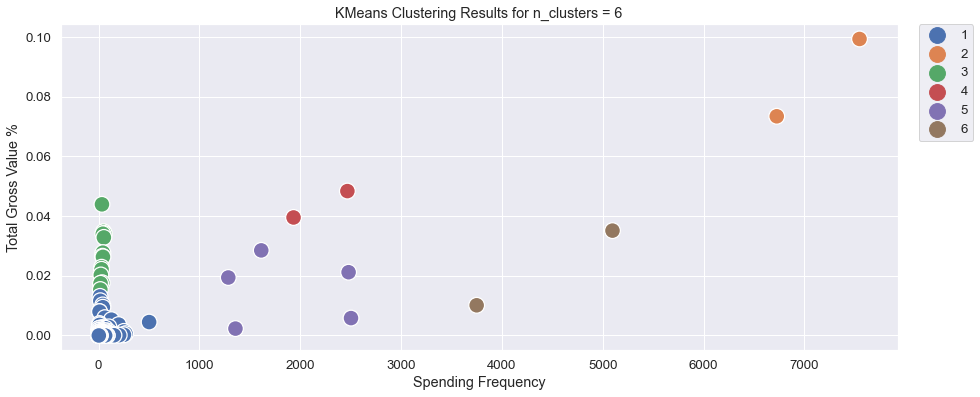

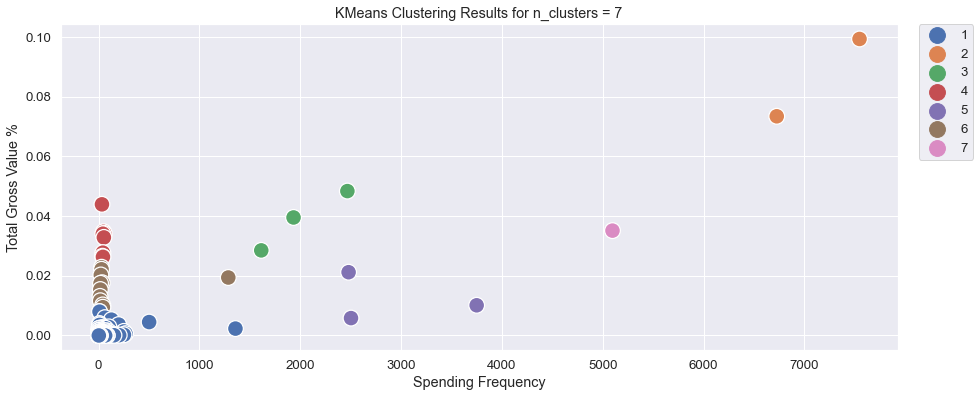

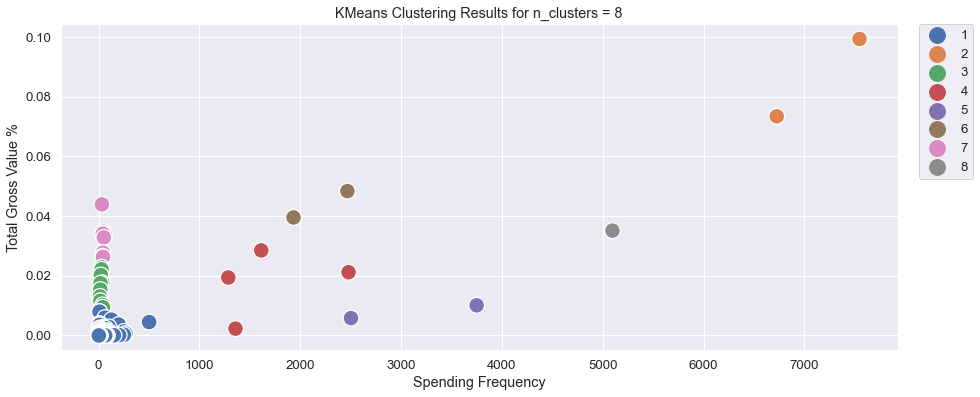

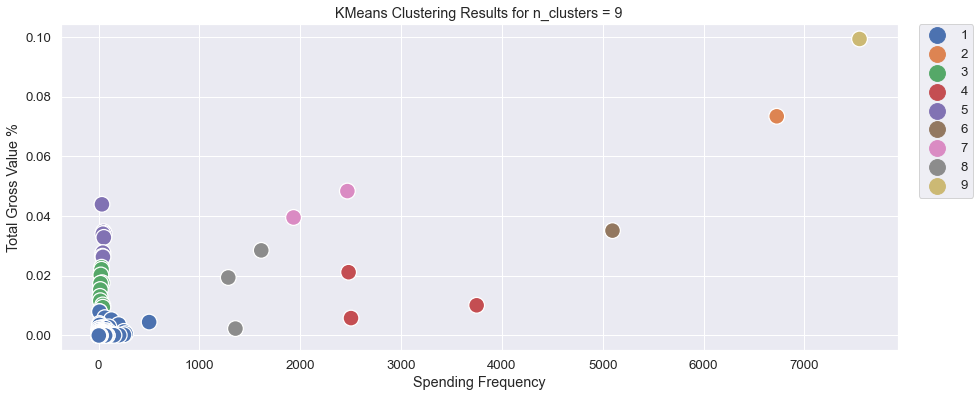

In [40]:
for n_clusters in n_clusters_range:

    with sns.plotting_context('notebook', font_scale=1.2):
        plt.figure(figsize=(15, 6))
        sns.scatterplot(
            data=df_dict[n_clusters], x=col_2, y=col_3, 
            hue=col_4, size=col_4, sizes=(250, 250), palette='deep', legend='full'
        )
        #plt.xlim(-1, 1000)
        #plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
        #plt.ylim(-0.005, 0.11)
        #plt.yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11])
        plt.title(f'KMeans Clustering Results for n_clusters = {n_clusters}')
        plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0.)
        plt.show()
    
    print()

**Affinity Propagation** - the results are subpar as this model either does not converge or produces too many (136) clusters.

C:\Users\Rafal\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


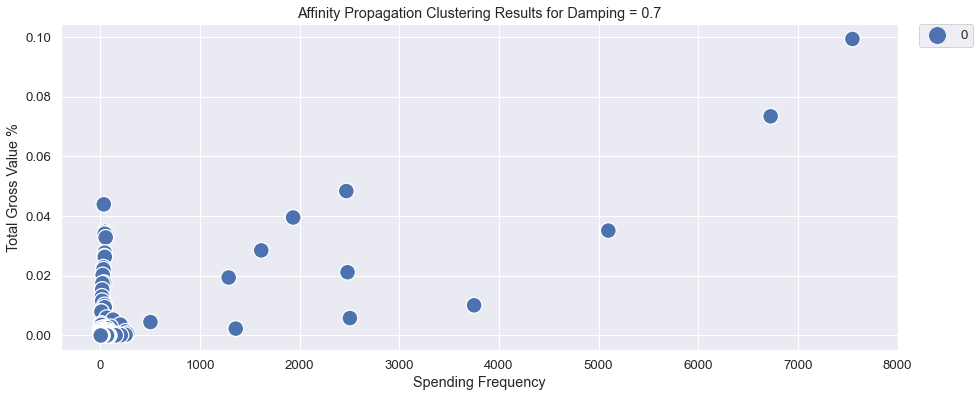

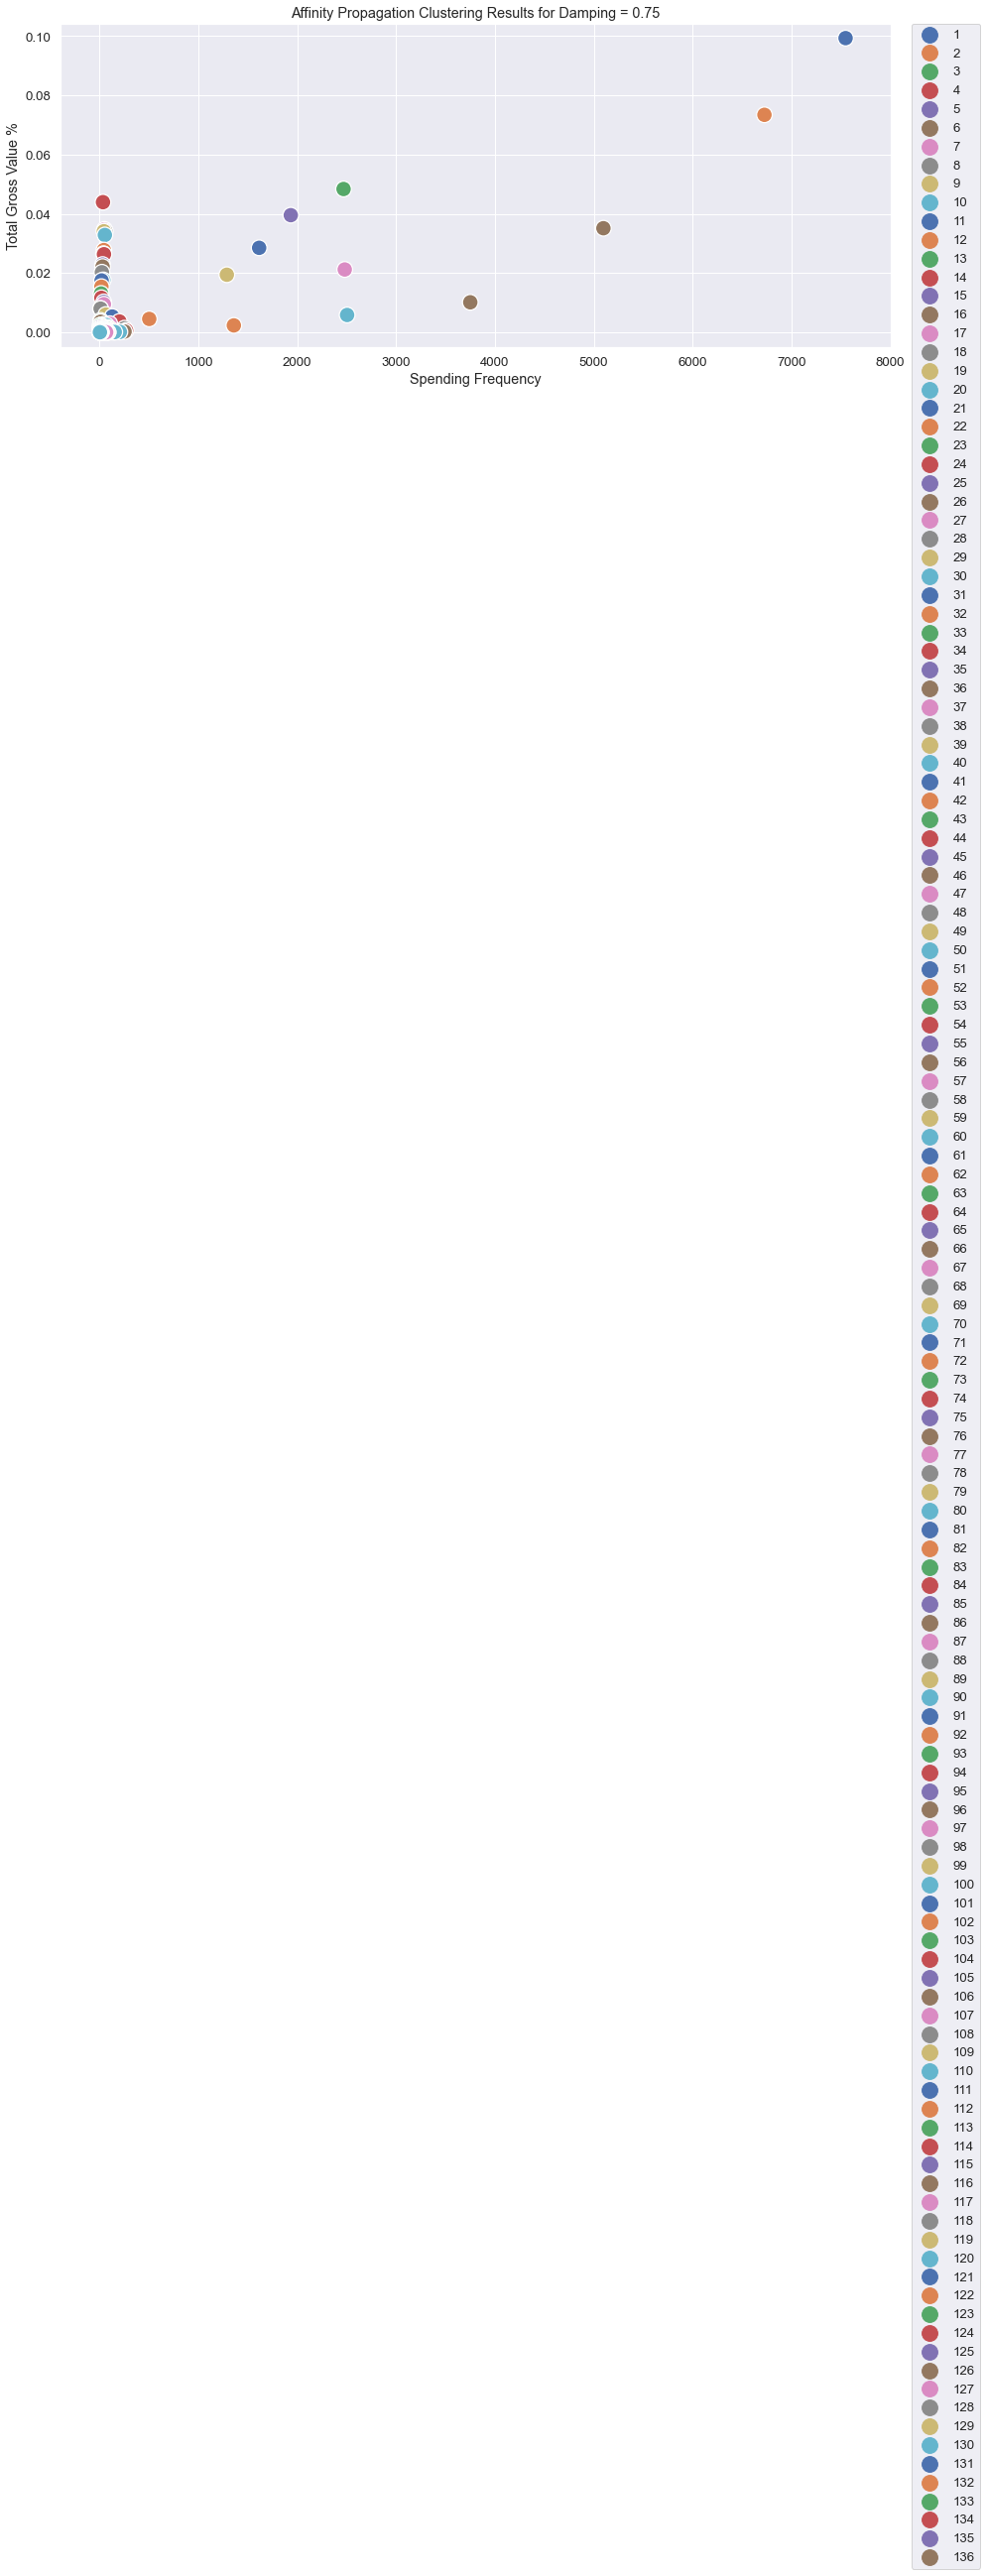



Wall time: 49.1 s


In [41]:
%%time

for damping in [0.7, 0.75]:
    
    model = AffinityPropagation(damping=damping, max_iter=1000, affinity='euclidean', random_state=RANDOM_STATE)
    pipeline = sklearn_pipeline([
    ('std_scaler', StandardScaler()),
    ('model', model)    
    ])
    pipeline.fit(df_cluster)

    df_affprop = df.copy()
    df_affprop['Cluster'] = 1 + pipeline['model'].labels_ 

    with sns.plotting_context('notebook', font_scale=1.2):
        plt.figure(figsize=(15, 6))
        sns.scatterplot(
            data=df_affprop, x=col_2, y=col_3, 
            hue=col_4, size=col_4, sizes=(250, 250), 
            palette='deep', #color_palette, 
            legend='full'
        )
        plt.xlim(-400, 8000)
        plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0.)
        plt.title(f'Affinity Propagation Clustering Results for Damping = {damping}')
        plt.show()
        
    print('\n')


**MeanShift** - the results are subpar as the model produces too many clusters (30 clusters).

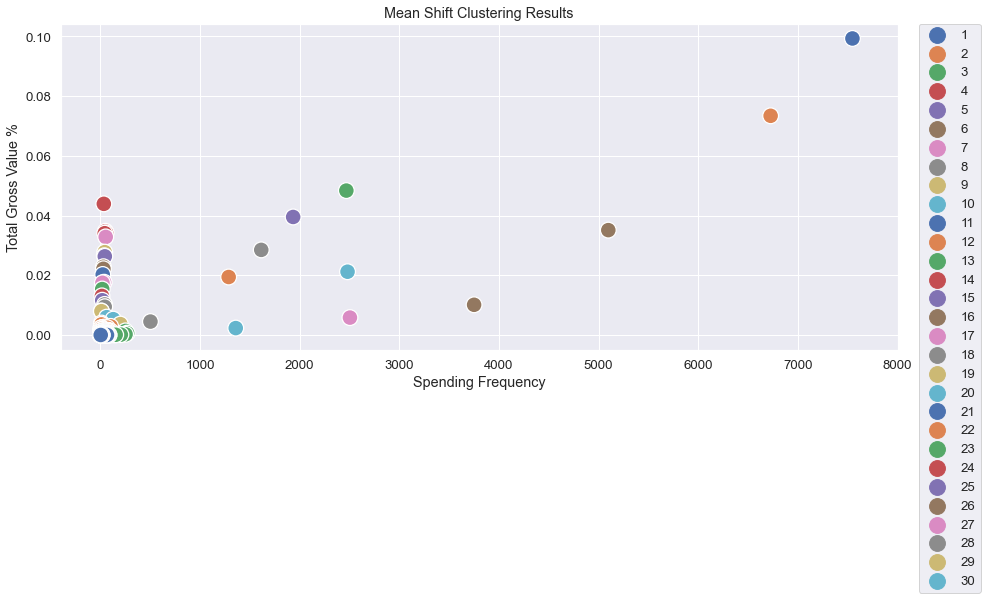

Wall time: 9.33 s


In [42]:
%%time

model = MeanShift(n_jobs=-1)
pipeline = sklearn_pipeline([
('std_scaler', StandardScaler()),
('model', model)    
])
pipeline.fit(df_cluster)

df_meanshift = df.copy()
df_meanshift['Cluster'] = 1 + pipeline['model'].labels_ 

with sns.plotting_context('notebook', font_scale=1.2):
    plt.figure(figsize=(15, 6))
    sns.scatterplot(
        data=df_meanshift, x=col_2, y=col_3, 
        hue=col_4, size=col_4, sizes=(250, 250), 
        palette='deep', #color_palette, 
        legend='full'
    )
    plt.xlim(-400, 8000)
    plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0.)
    plt.title('Mean Shift Clustering Results')
    plt.show()
        
    #print('\n')


**Spectral Clustering** - the results are not ideal as manual cluster merging is required.

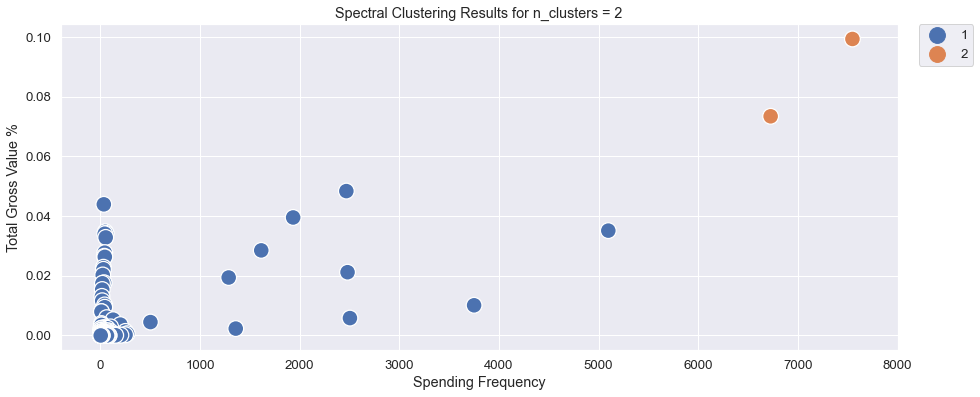

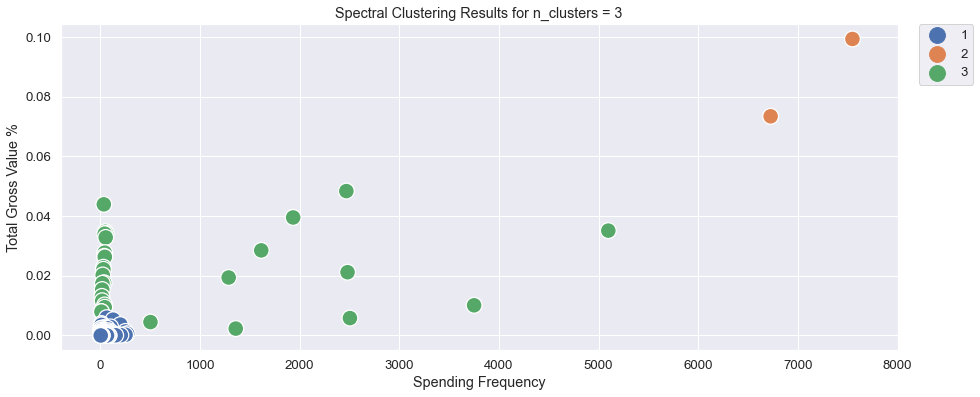

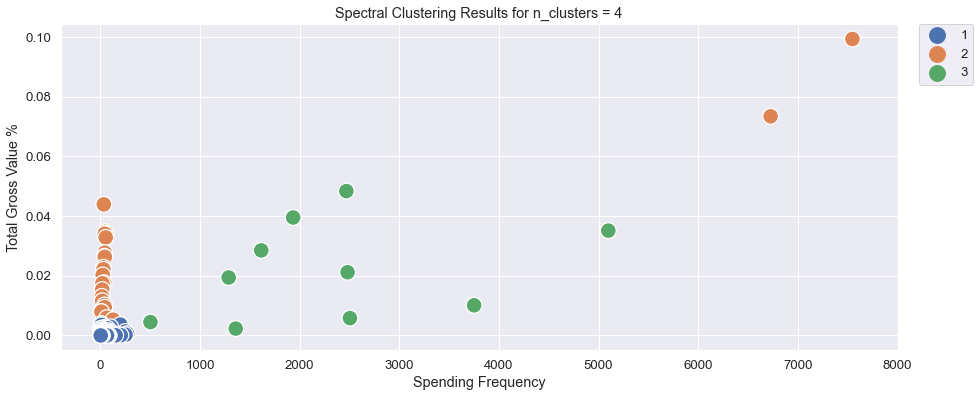

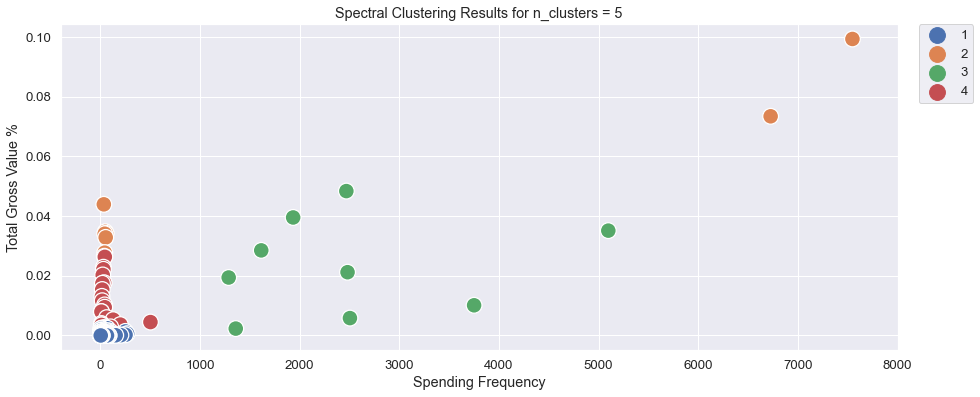

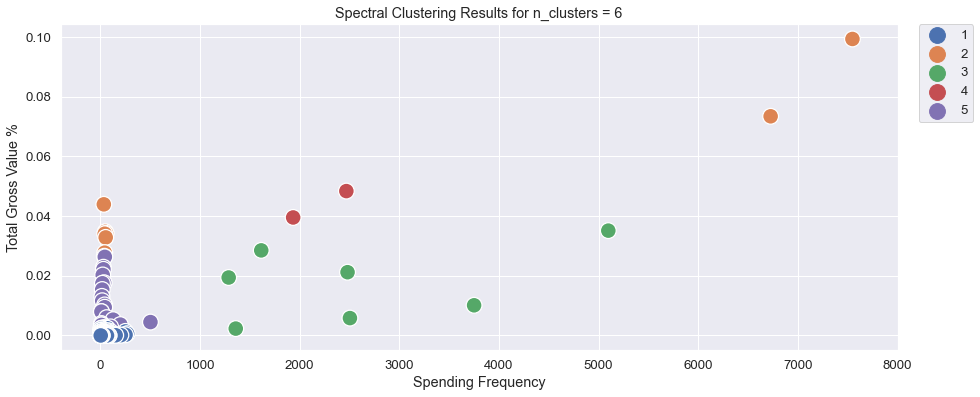

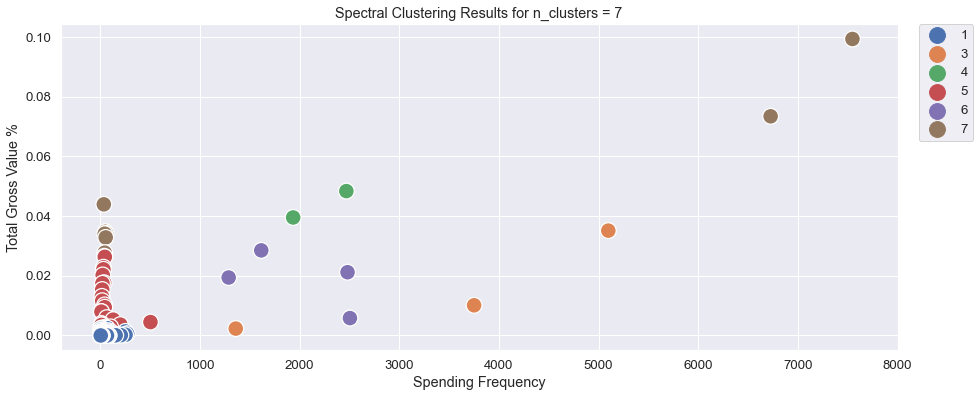

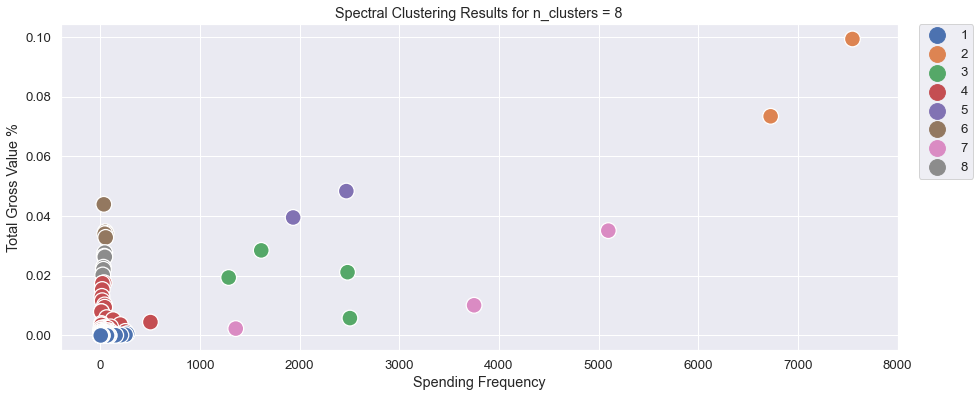

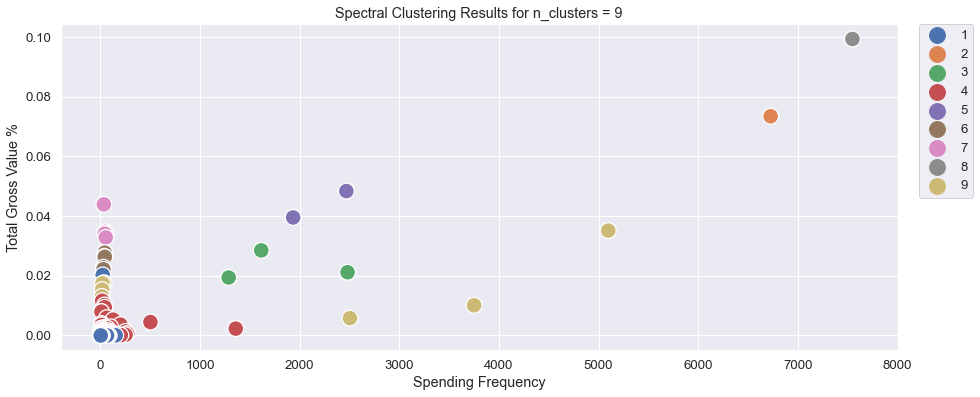

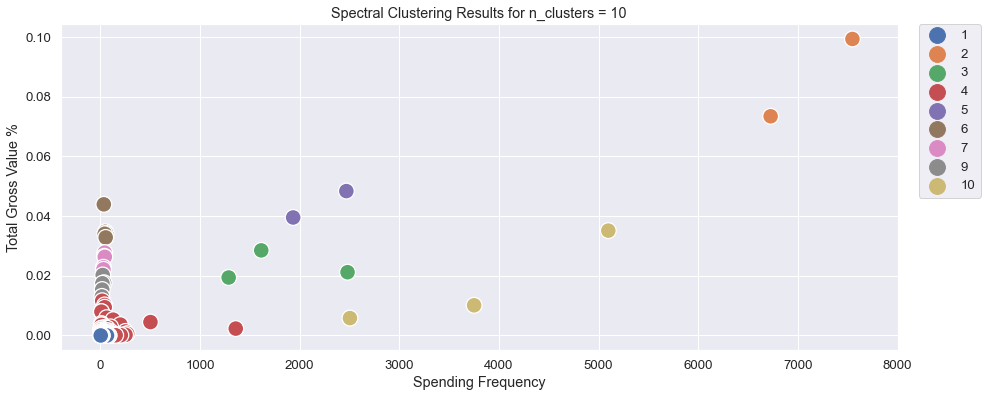



Wall time: 4.99 s


In [43]:
%%time

for n_clusters in range(2, 11):
    model = SpectralClustering(
        n_clusters=n_clusters, 
        affinity='rbf', 
        assign_labels = 'discretize', 
        random_state=RANDOM_STATE ,
        n_jobs=-1
    )
    pipeline = sklearn_pipeline([
    ('std_scaler', StandardScaler()),
    ('model', model)    
    ])
    pipeline.fit(df_cluster)

    df_spectral = df.copy()
    df_spectral['Cluster'] = 1 + pipeline['model'].labels_ 

    with sns.plotting_context('notebook', font_scale=1.2):
        plt.figure(figsize=(15, 6))
        sns.scatterplot(
            data=df_spectral, x=col_2, y=col_3, 
            hue=col_4, size=col_4, sizes=(250, 250), 
            palette='deep', #color_palette, 
            legend='full'
        )
        plt.xlim(-400, 8000)
        plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0.)
        plt.title(f'Spectral Clustering Results for n_clusters = {n_clusters}')
        plt.show()
        
    print('\n')


**Agglomerative Clustering** -  the results are not ideal as manual cluster merging is required.

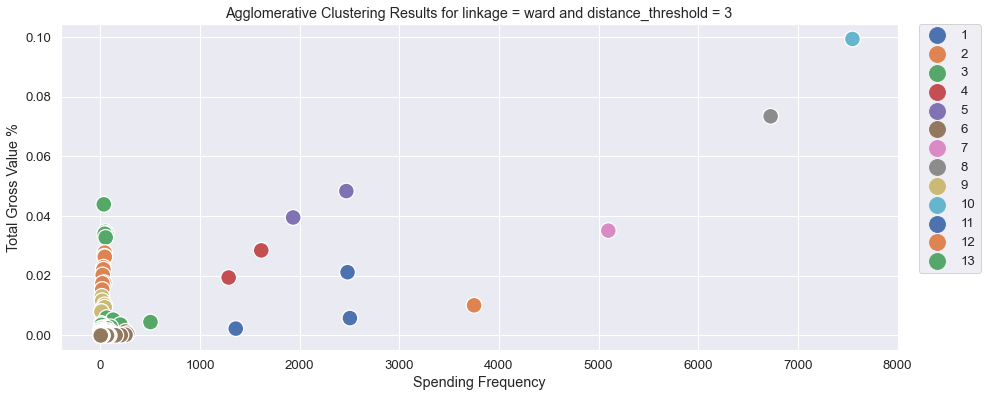

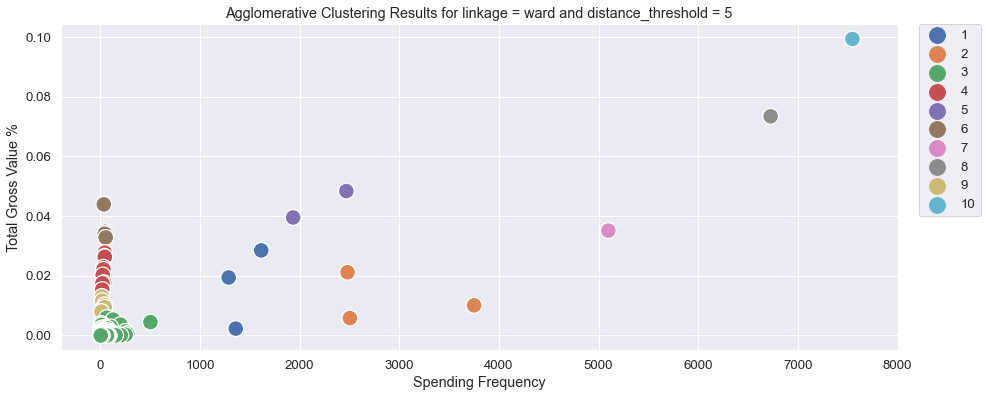

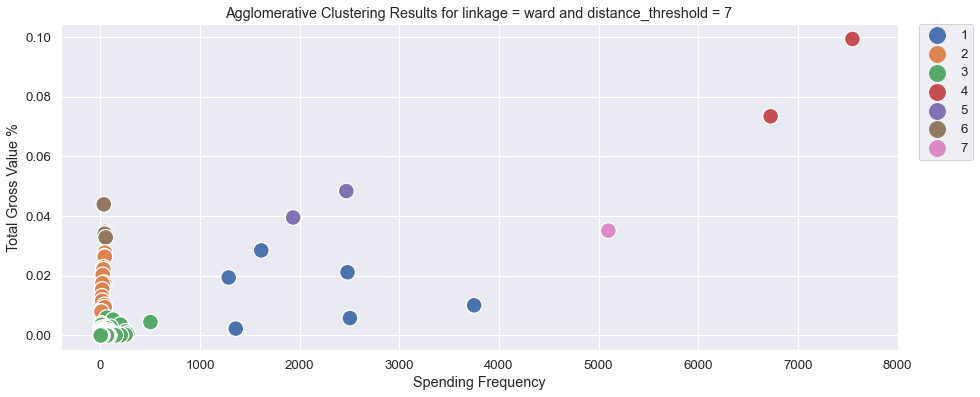

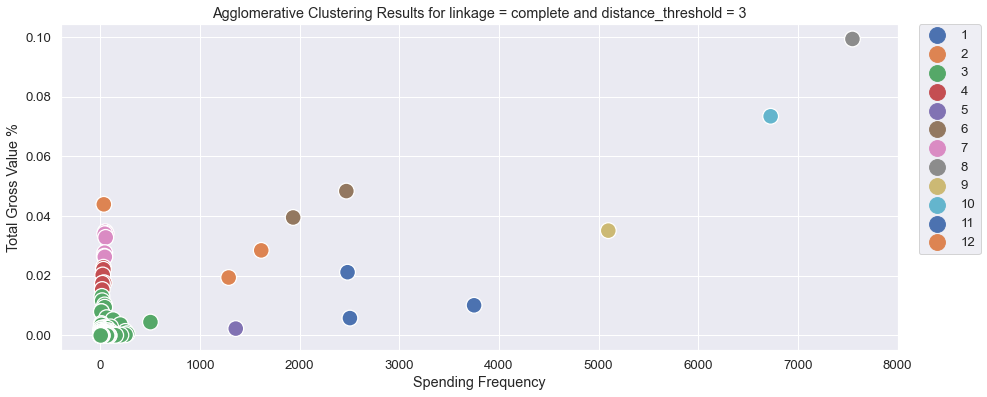

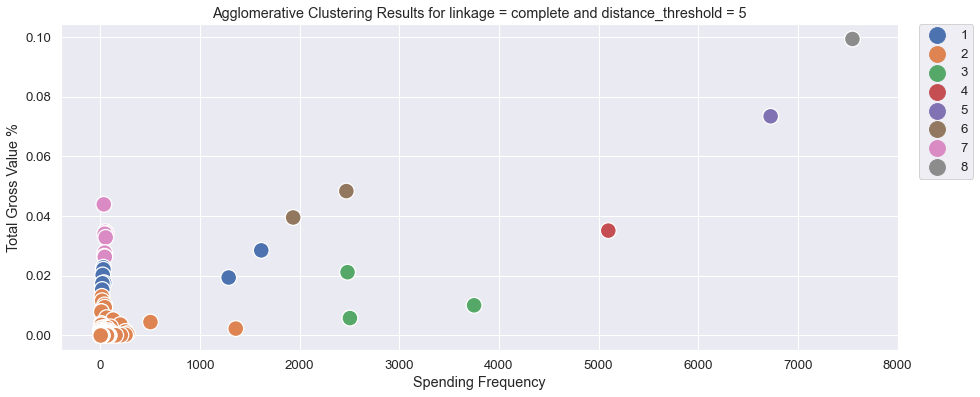

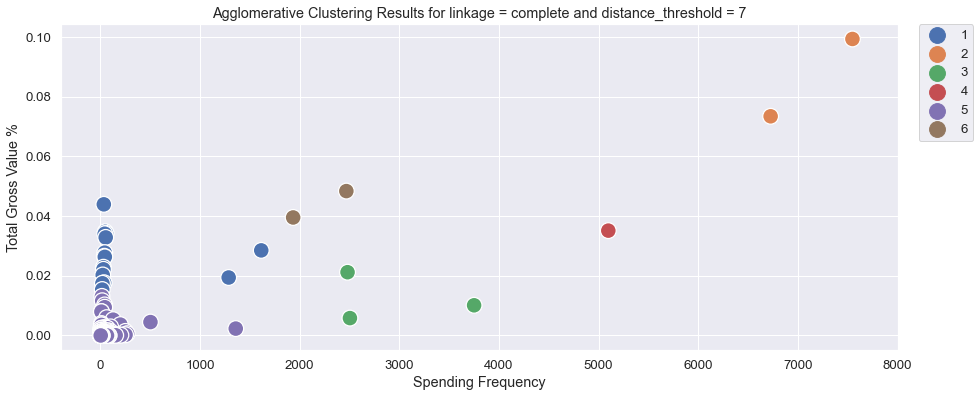

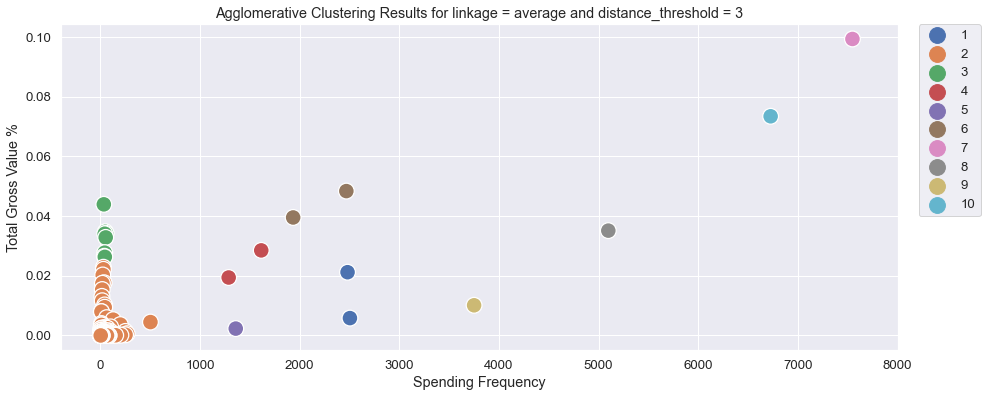

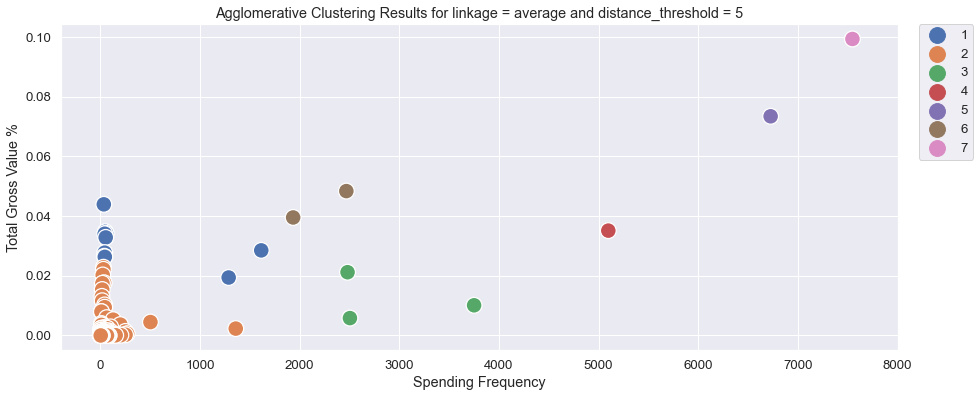

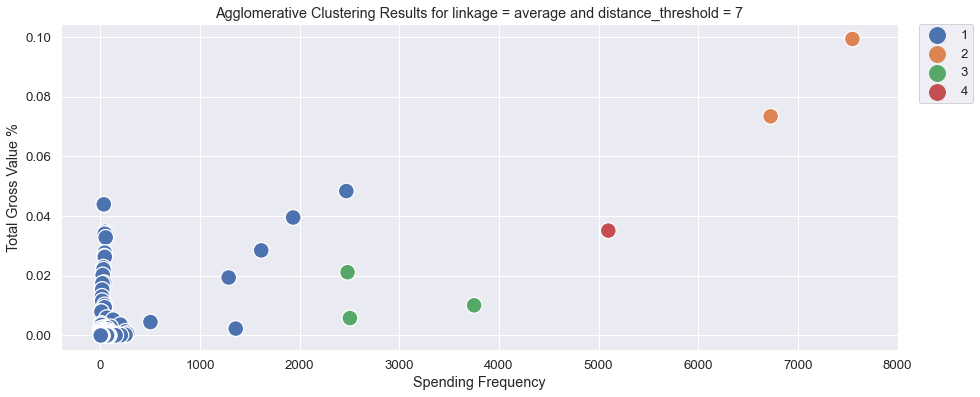

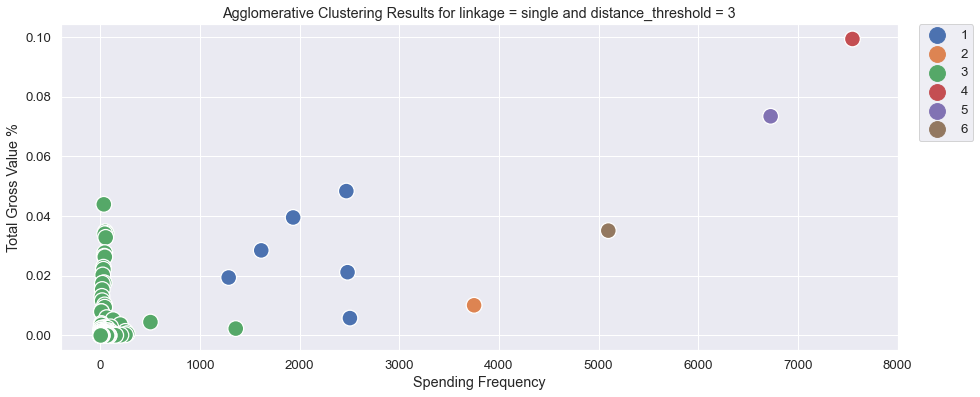

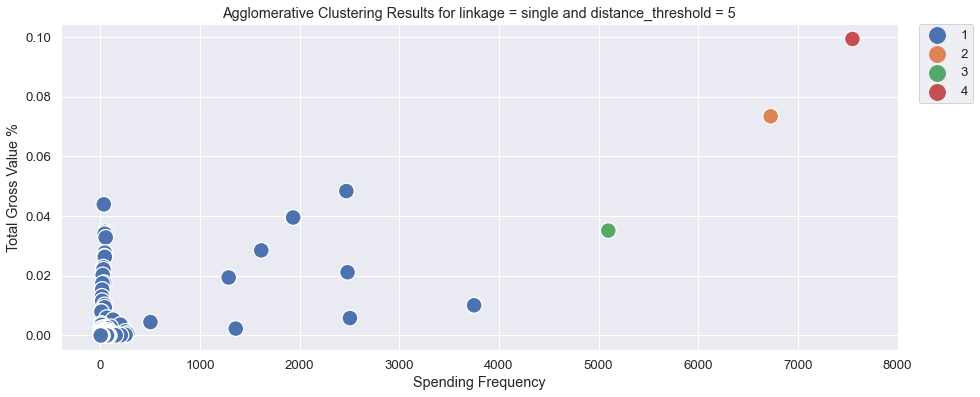

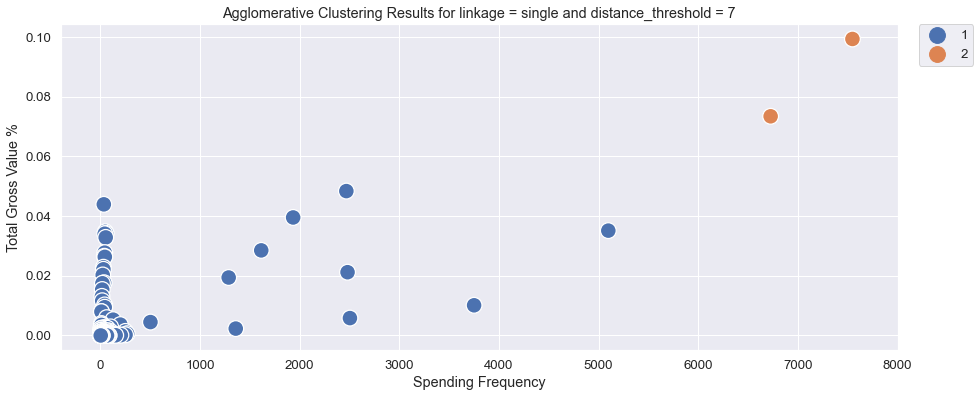



Wall time: 5.09 s


In [44]:
%%time

for  linkage in ['ward', 'complete', 'average', 'single']:
    for distance_threshold in [3, 5, 7]:
        model = AgglomerativeClustering(n_clusters=None, linkage=linkage, distance_threshold=distance_threshold)
        pipeline = sklearn_pipeline([
        ('std_scaler', StandardScaler()),
        ('model', model)    
        ])
        pipeline.fit(df_cluster)

        df_agglom = df.copy()
        df_agglom['Cluster'] = 1 + pipeline['model'].labels_ 

        with sns.plotting_context('notebook', font_scale=1.2):
            plt.figure(figsize=(15, 6))
            sns.scatterplot(
                data=df_agglom, x=col_2, y=col_3, 
                hue=col_4, size=col_4, sizes=(250, 250), 
                palette='deep', #color_palette, 
                legend='full'
            )
            plt.xlim(-400, 8000)
            plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0.)
            plt.title(f'Agglomerative Clustering Results for linkage = {linkage} and distance_threshold = {distance_threshold}')
            plt.show()

        print('\n')


**DBSCAN** appears to be best suited for our data. After applying this clustering algorithm we can see that the main cluster (composed of red points, see below) consists of low frequency combinations while those loosely scattered green points mostly represent the combinations exhibiting both relatively high value and high frequency.

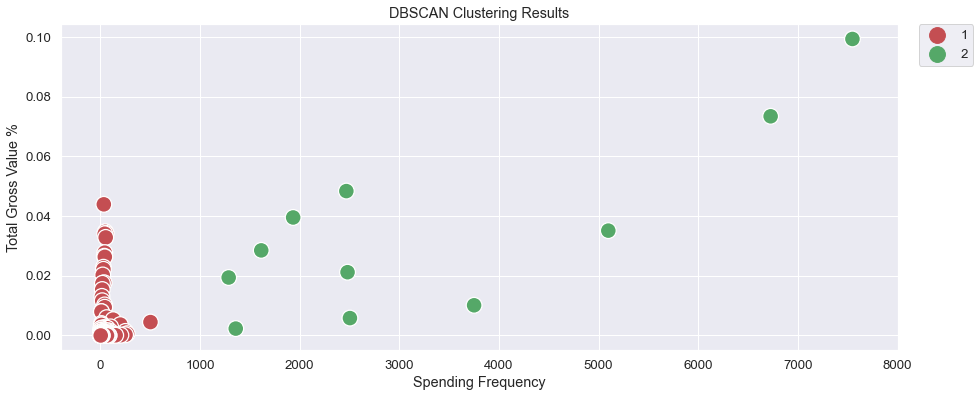

Wall time: 466 ms


In [45]:
%%time

model = DBSCAN(eps=2, metric='euclidean', n_jobs=-1)
pipeline = sklearn_pipeline([
('std_scaler', StandardScaler()),
('model', model)    
])
pipeline.fit(df_cluster)

df_dbscan = df.copy()
df_dbscan['Cluster'] = 1 - pipeline['model'].labels_ 

with sns.plotting_context('notebook', font_scale=1.2):
    plt.figure(figsize=(15, 6))
    sns.scatterplot(
        data=df_dbscan, x=col_2, y=col_3, 
        hue=col_4, size=col_4, sizes=(250, 250), 
        palette=color_palette, 
        legend='full'
    )
    plt.xlim(-400, 8000)
    plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0.)
    plt.title('DBSCAN Clustering Results')
    plt.show()


And exactly those green points, listed below, form our list of potential saving opportunities (that are in line with our business intuition that we should look for such opportunities among high-value and high-moving products) which we will analyze presently.

In [46]:
df_selected = df_dbscan.loc[df_dbscan['Cluster'] == 2, :]
df_selected

Total Gross Value %  \
CoCd Material  Short Text                                              
7860 7101320.0 IB Ross Broiler Finisher Feed                0.099324   
               IB Ross Broiler Starter Feed                 0.073418   
9000 910970.0  Soya Bean - (MP)                             0.048367   
     910070.0  Soya Bean - (A)                              0.039531   
7860 7101320.0 IB Ross Broiler Pre-Starter Feed             0.035124   
9000 910010.0  Maize                                        0.028506   
     910000.0  Soya Bean                                    0.021192   
     910860.0  Khandha                                      0.019418   
     910420.0  Rice Bran Boiled                             0.010110   
               Rice Bran Raw                                0.005824   
     940730.0  Rice Husk (New)                              0.002309   

                                                 Spending Frequency  \
CoCd Material  Short Text                                             
7860 7101320.0 IB Ross Broiler Finisher Feed                   7547   
               IB Ross Broiler Starter Feed                    6726   
9000 910970.0  Soya Bean - (MP)                                2468   
     910070.0  Soya Bean - (A)                                 1934   
7860 7101320.0 IB Ross Broiler Pre-Starter Feed                5097   
9000 910010.0  Maize                                           1614   
     910000.0  Soya Bean                                       2480   
     910860.0  Khandha                                         1287   
     910420.0  Rice Bran Boiled                                3750   
               Rice Bran Raw                                   2504   
     940730.0  Rice Husk (New)                                 1358   

                                                 Spending Days  Cluster  
CoCd Material  Short Text                                                
7860 7101320.0 IB Ross Broiler Finisher Feed                89        2  
               IB Ross Broiler Starter Feed                 89        2  
9000 910970.0  Soya Bean - (MP)                             88        2  
     910070.0  Soya Bean - (A)                              87        2  
7860 7101320.0 IB Ross Broiler Pre-Starter Feed             89        2  
9000 910010.0  Maize                                        79        2  
     910000.0  Soya Bean                                    88        2  
     910860.0  Khandha                                      86        2  
     910420.0  Rice Bran Boiled                             87        2  
               Rice Bran Raw                                86        2  
     940730.0  Rice Husk (New)                              84        2

In [47]:
n_opportunities = df_selected.shape[0]
retained_spending_pct = np.round(100 * df_selected['Total Gross Value %'].sum(), 3)
print(f'We can see that these {n_opportunities} combinations amount to {retained_spending_pct}% of total spending')

We can see that these 11 combinations amount to 38.312% of total spending


### Looking for savings - our strategy (main idea presented below, technical description in the code comments)

**Idea**: Given the upward price trend, replace the net prices of a given product paid during the period with the median daily price of the first purchase day of that period in order to generate savings.

**Assumptions**: 
- The products are easy to store in large quantities for an extended period of time 
- There is enough storage capacity for a bulk purchase (optionally, several deliveries for one bulk order can be scheduled) 

Company code: 7860,  Material: 7101320,  Description: IB Ross Broiler Finisher Feed


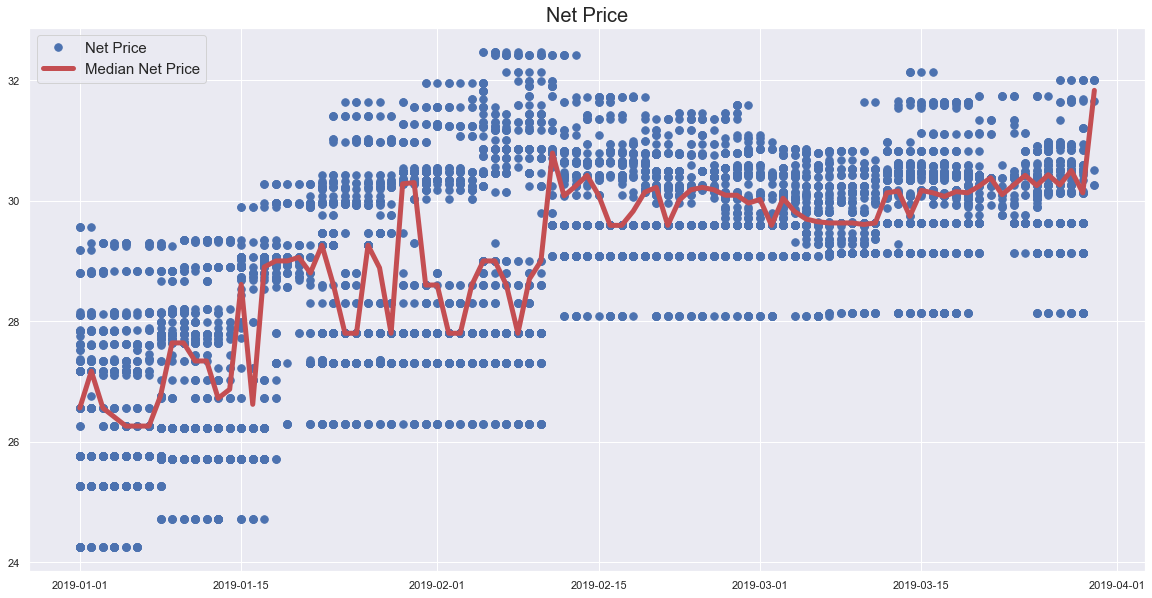

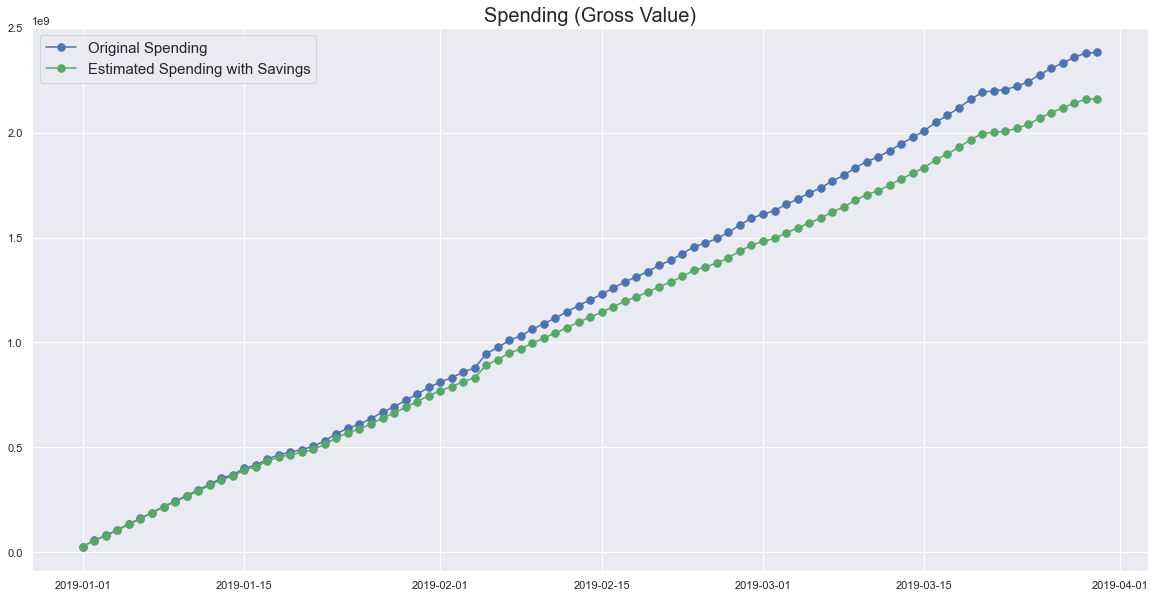

Local savings percentage (at the given drilled down level) at the end of the given period: 0.09252568988165404
Global savings percentage (at the given drilled down level) at the end of the given period: 0.009190015901519482
-------------------------------------------------------------------------------------------------------------------



Company code: 7860,  Material: 7101320,  Description: IB Ross Broiler Starter Feed


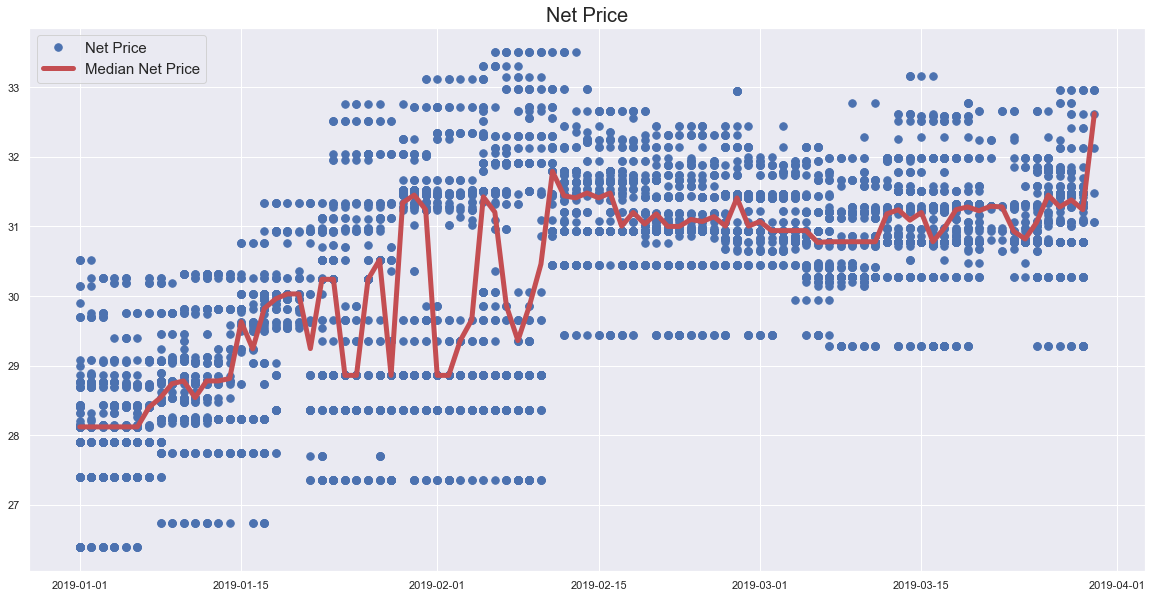

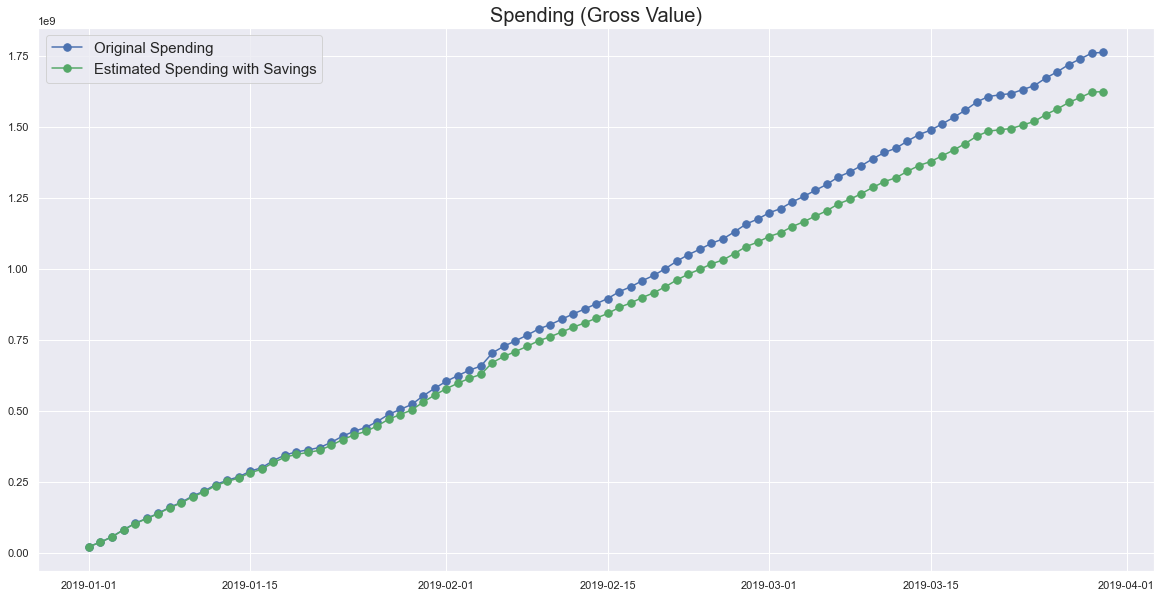

Local savings percentage (at the given drilled down level) at the end of the given period: 0.07832841307080919
Global savings percentage (at the given drilled down level) at the end of the given period: 0.005750752181669148
-------------------------------------------------------------------------------------------------------------------



Company code: 9000,  Material: 910970,  Description: Soya Bean - (MP)


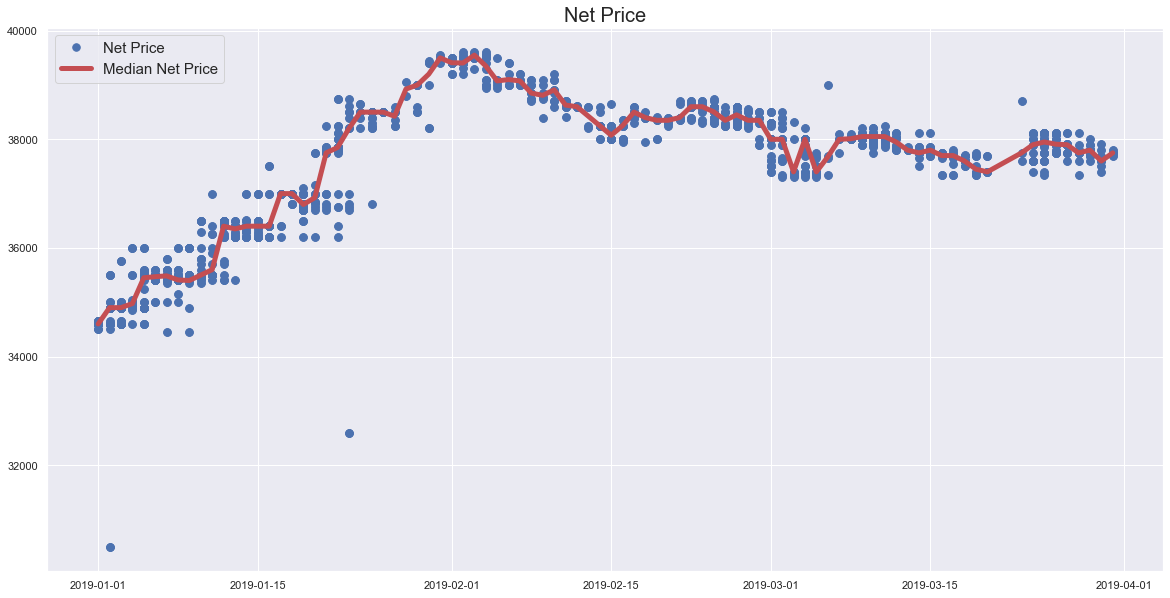

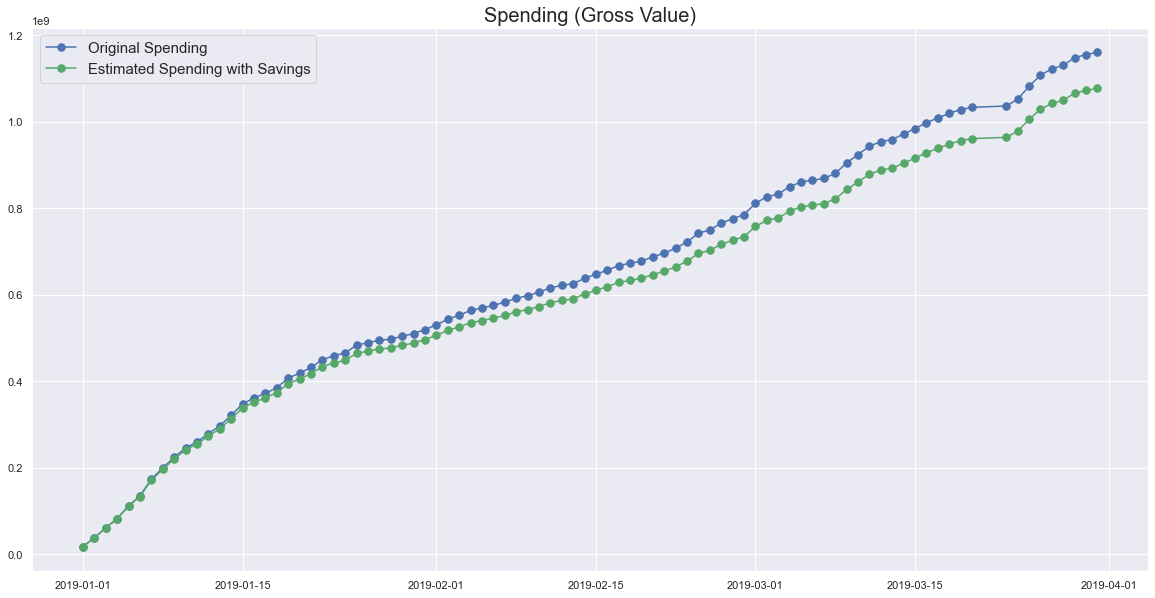

Local savings percentage (at the given drilled down level) at the end of the given period: 0.07169174370931124
Global savings percentage (at the given drilled down level) at the end of the given period: 0.003467547521019417
-------------------------------------------------------------------------------------------------------------------



Company code: 9000,  Material: 910070,  Description: Soya Bean - (A)


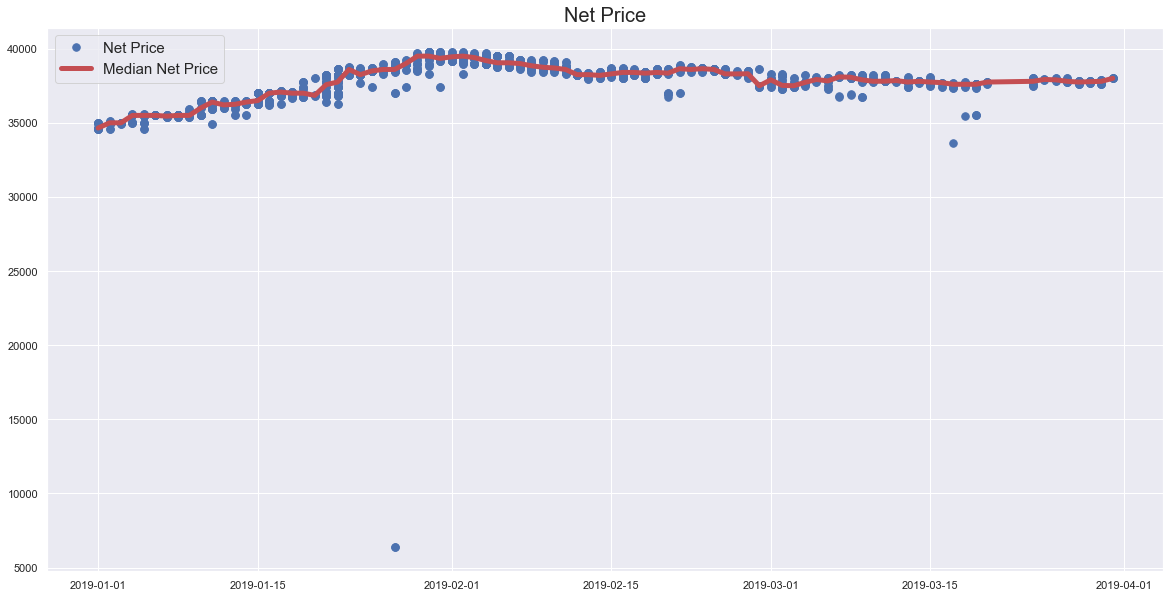

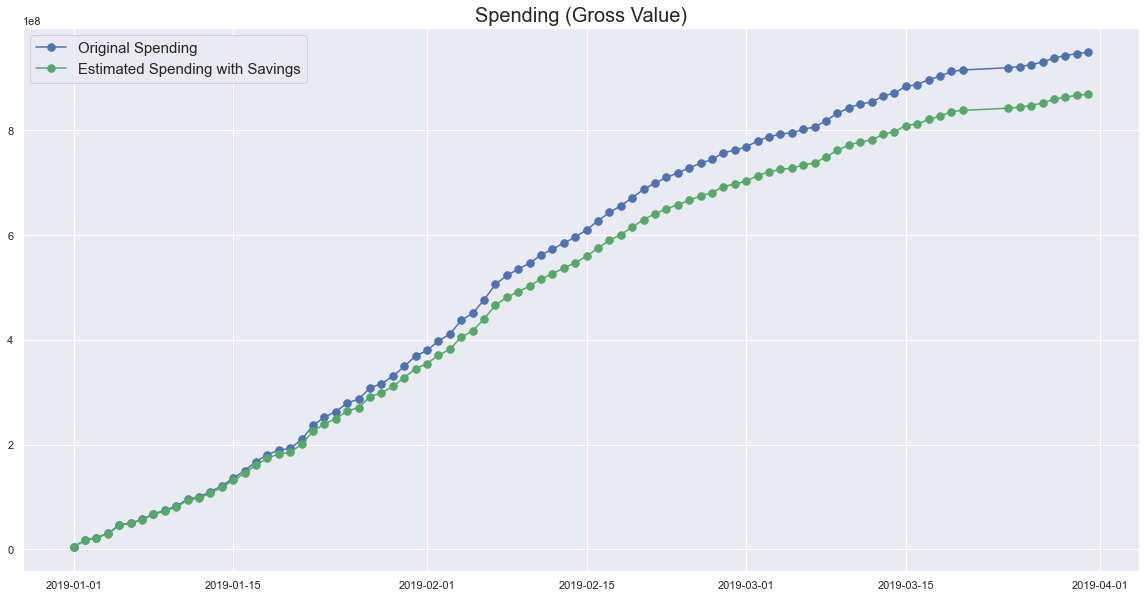

Local savings percentage (at the given drilled down level) at the end of the given period: 0.08416873044612118
Global savings percentage (at the given drilled down level) at the end of the given period: 0.0033272571014716346
-------------------------------------------------------------------------------------------------------------------



Company code: 7860,  Material: 7101320,  Description: IB Ross Broiler Pre-Starter Feed


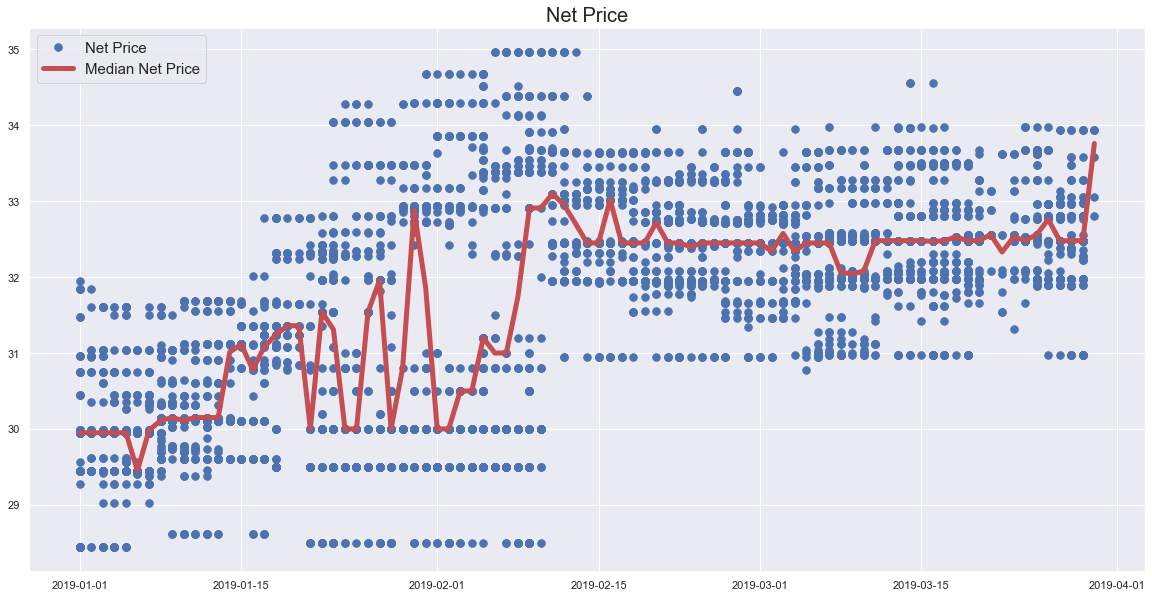

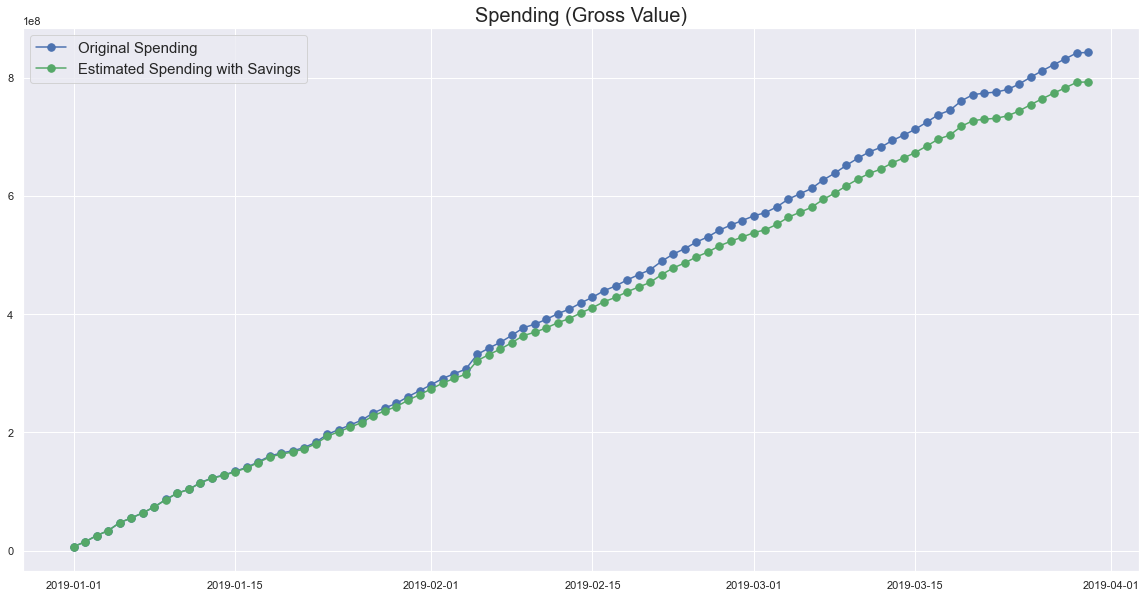

Local savings percentage (at the given drilled down level) at the end of the given period: 0.05914513998645312
Global savings percentage (at the given drilled down level) at the end of the given period: 0.0020774332482090376
-------------------------------------------------------------------------------------------------------------------



Company code: 9000,  Material: 910010,  Description: Maize


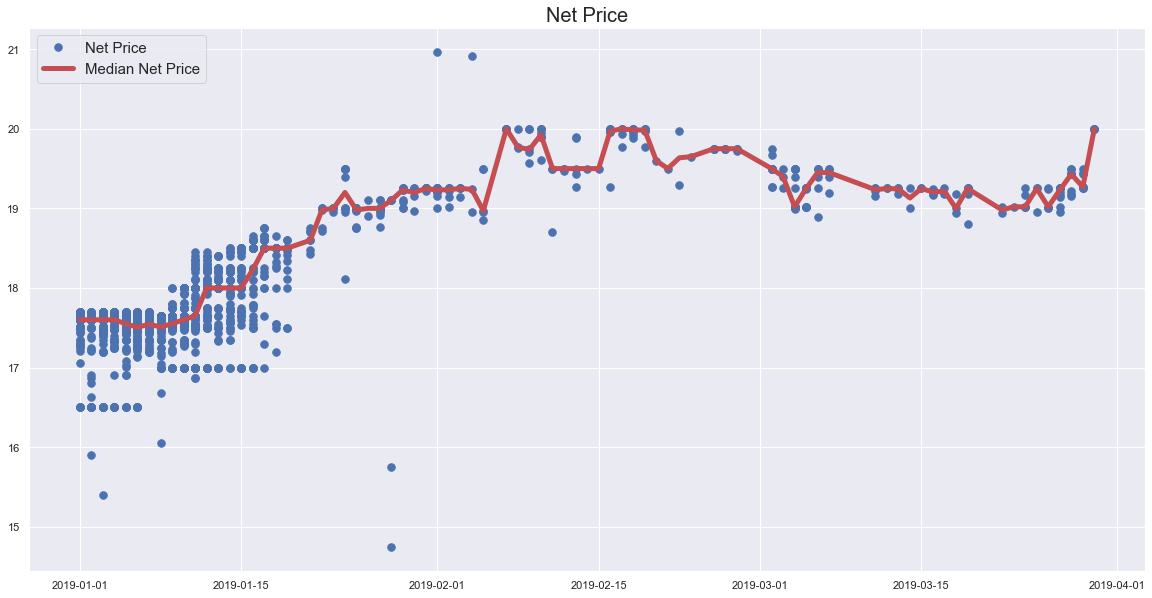

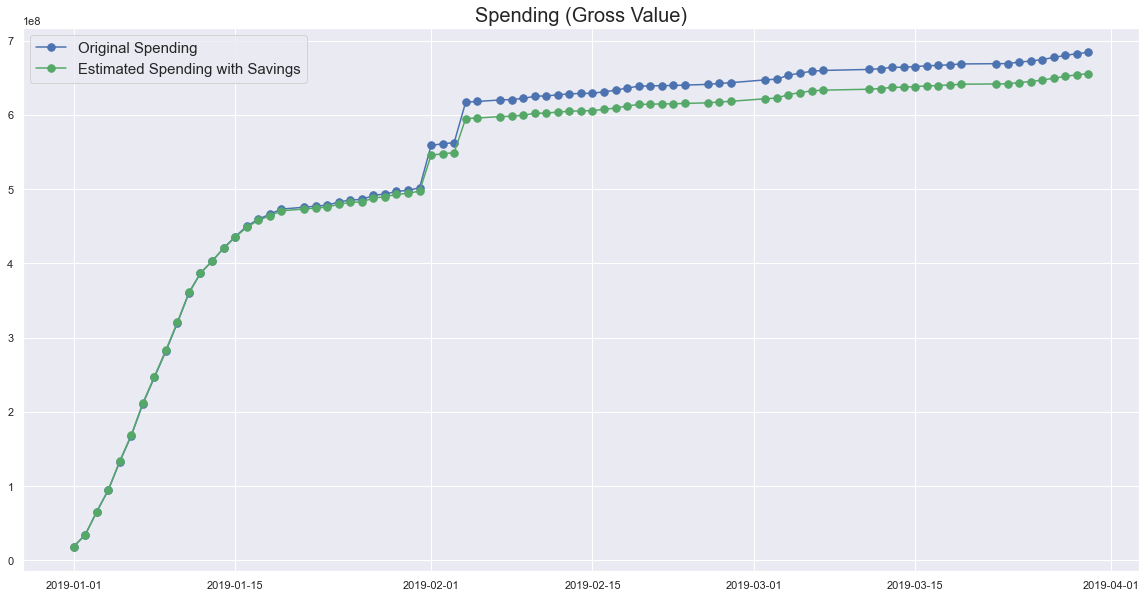

Local savings percentage (at the given drilled down level) at the end of the given period: 0.041877716405725234
Global savings percentage (at the given drilled down level) at the end of the given period: 0.001193772715107899
-------------------------------------------------------------------------------------------------------------------



Company code: 9000,  Material: 910000,  Description: Soya Bean


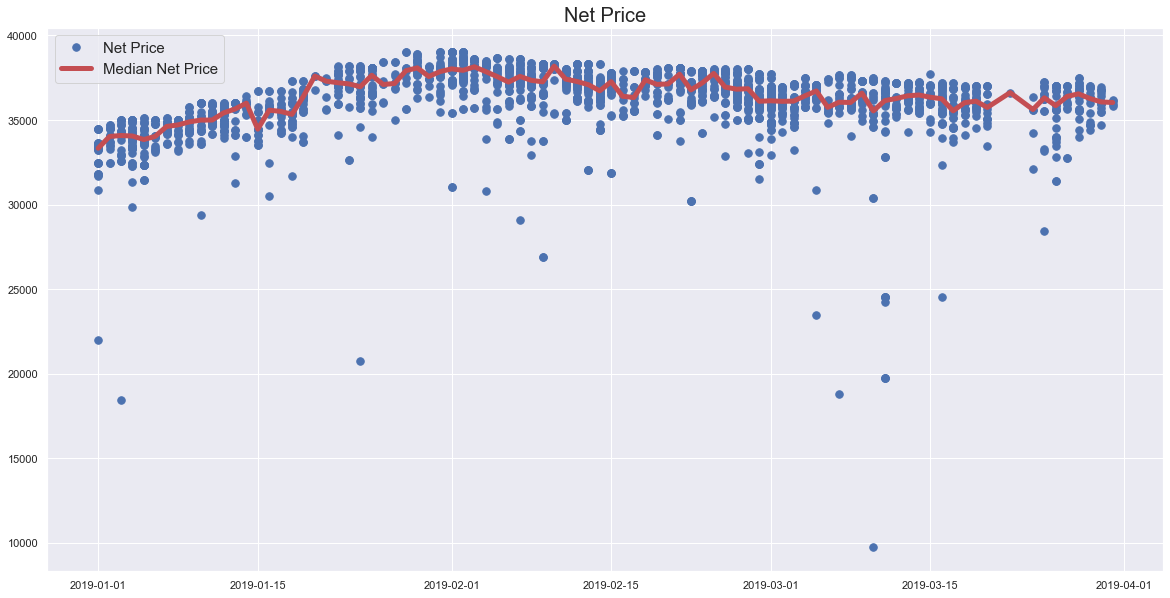

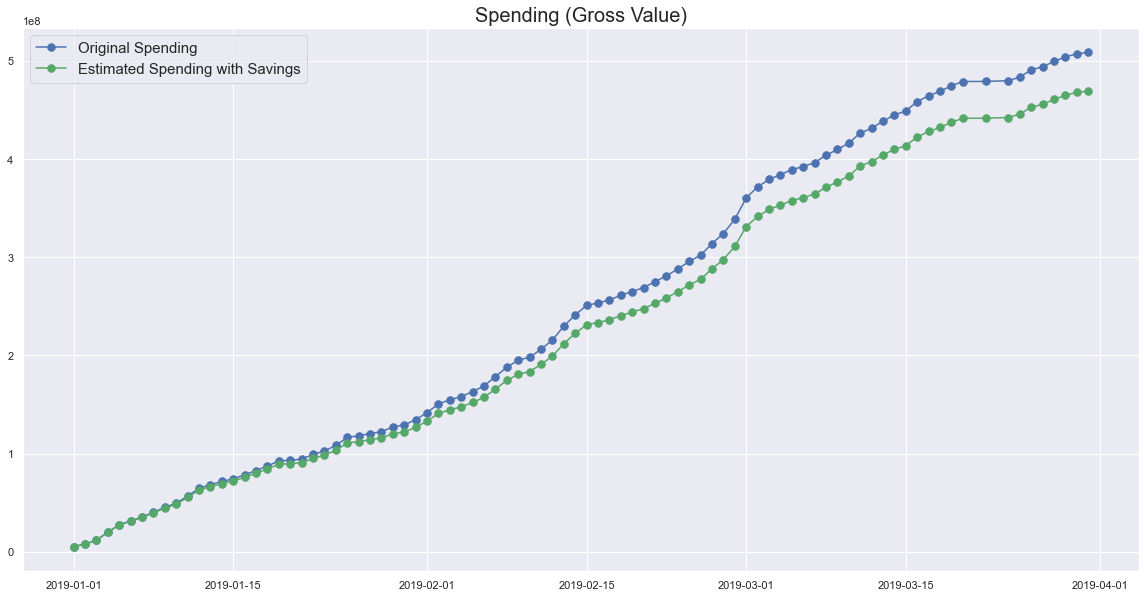

Local savings percentage (at the given drilled down level) at the end of the given period: 0.07741505716018593
Global savings percentage (at the given drilled down level) at the end of the given period: 0.0016406172629528462
-------------------------------------------------------------------------------------------------------------------



Company code: 9000,  Material: 910860,  Description: Khandha


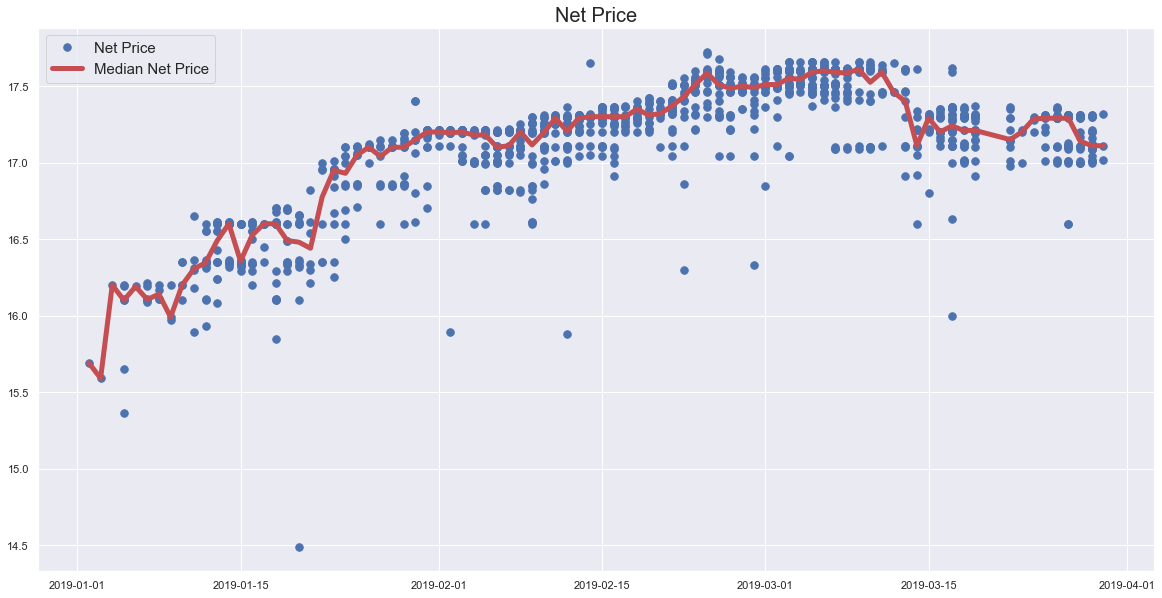

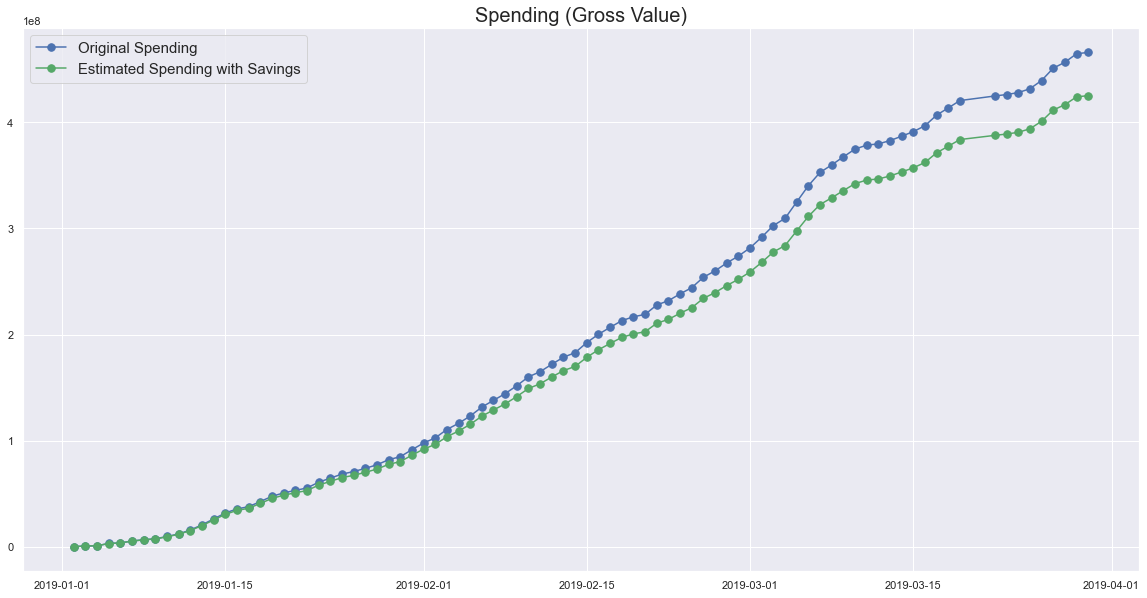

Local savings percentage (at the given drilled down level) at the end of the given period: 0.08747435650306638
Global savings percentage (at the given drilled down level) at the end of the given period: 0.0016985893691555869
-------------------------------------------------------------------------------------------------------------------



Company code: 9000,  Material: 910420,  Description: Rice Bran Boiled


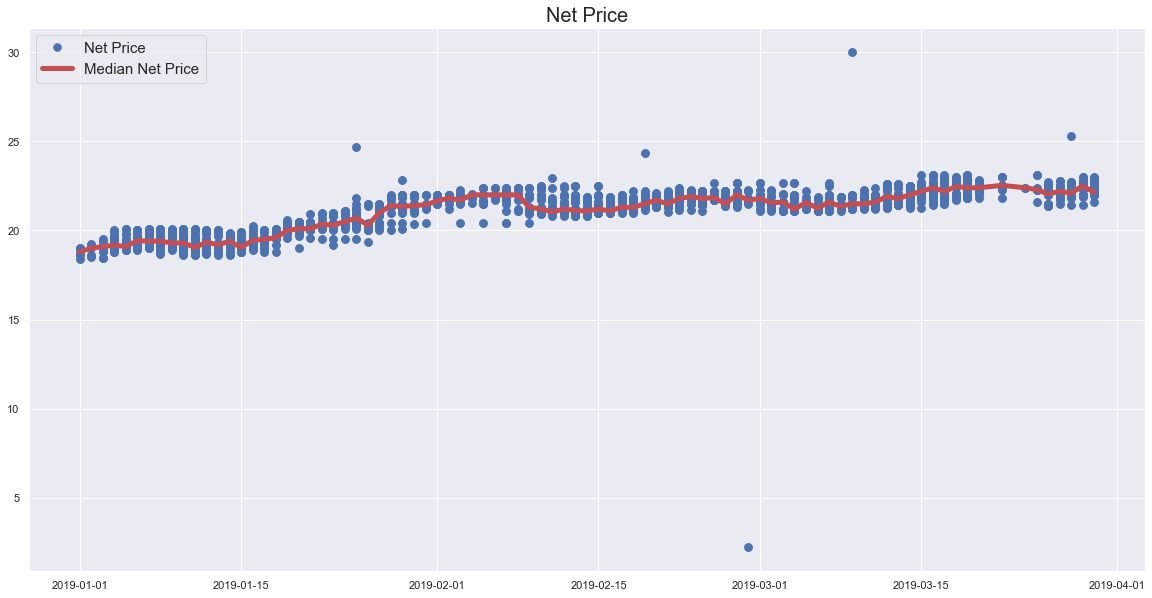

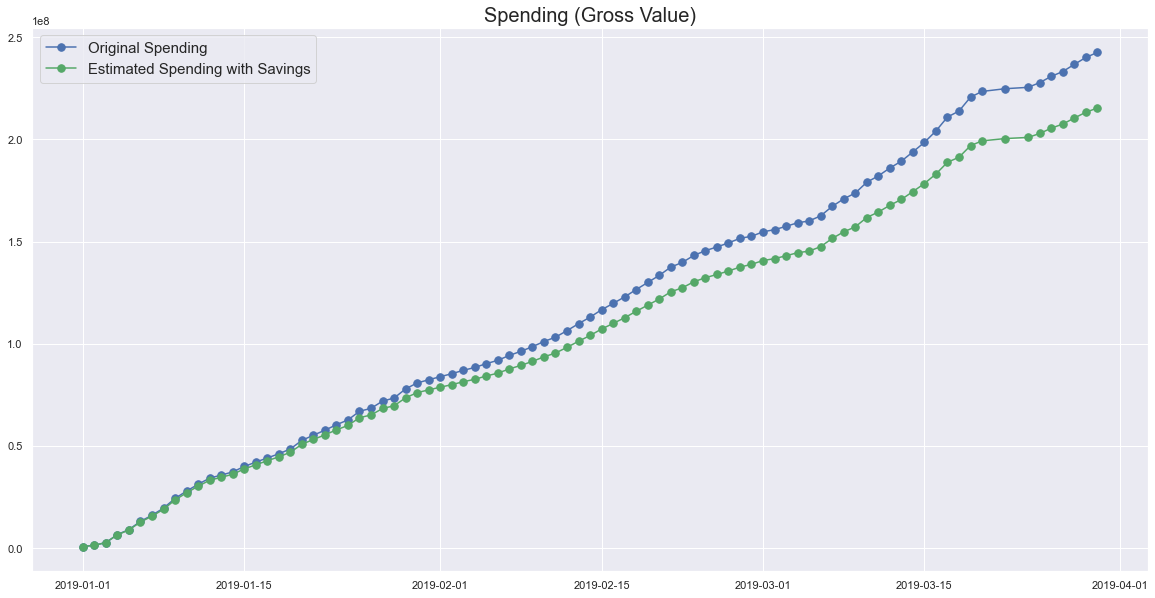

Local savings percentage (at the given drilled down level) at the end of the given period: 0.11220797121391143
Global savings percentage (at the given drilled down level) at the end of the given period: 0.001134398683371599
-------------------------------------------------------------------------------------------------------------------



Company code: 9000,  Material: 910420,  Description: Rice Bran Raw


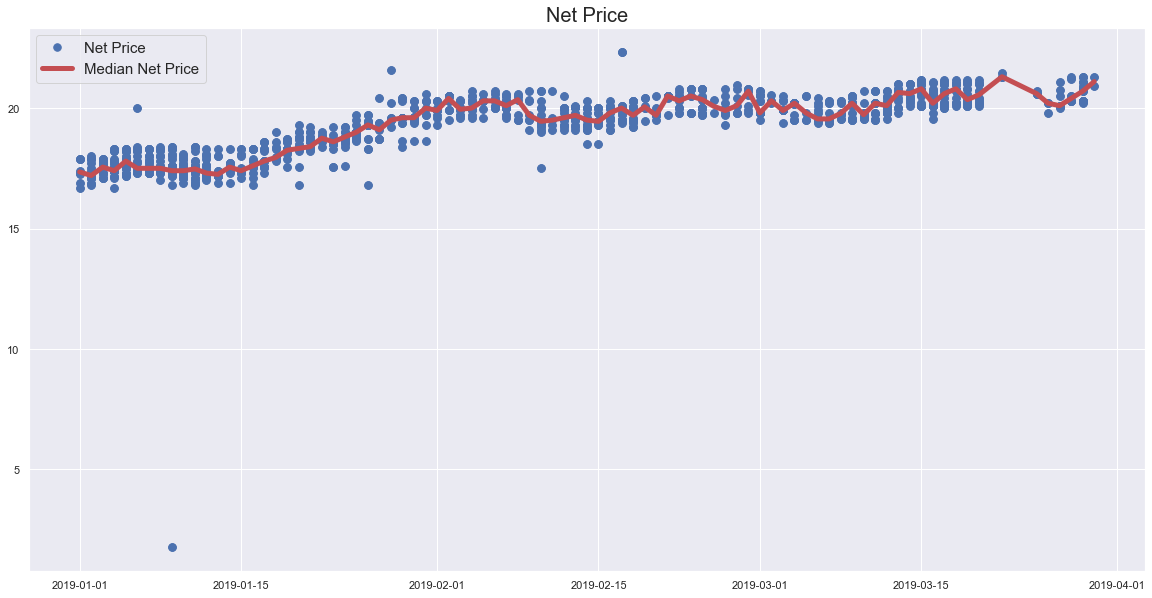

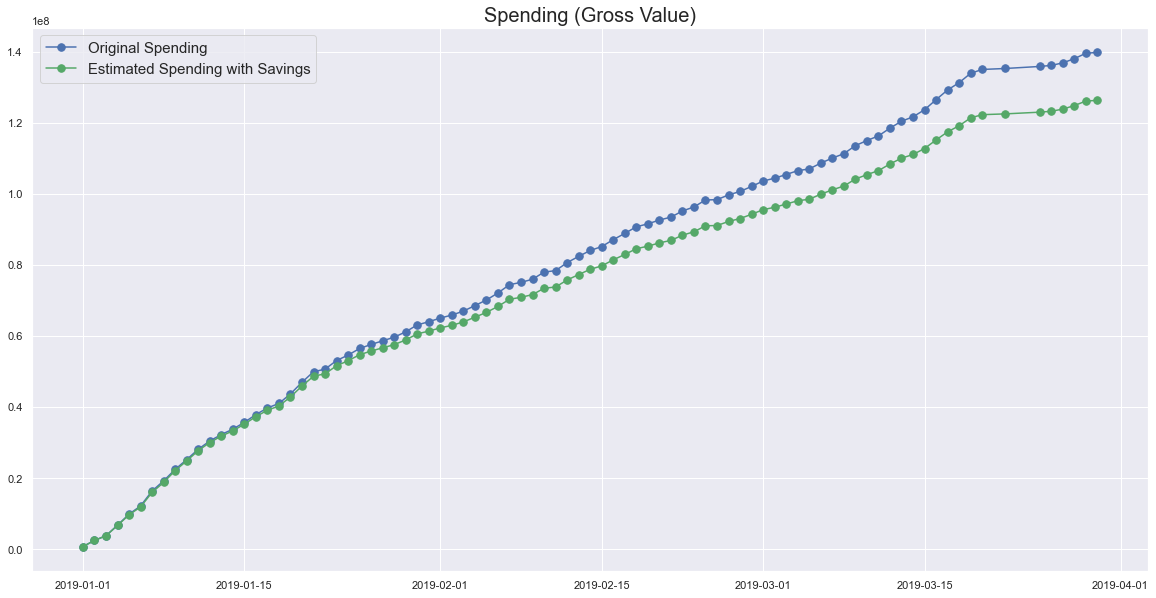

Local savings percentage (at the given drilled down level) at the end of the given period: 0.0965045355236
Global savings percentage (at the given drilled down level) at the end of the given period: 0.0005620244915253574
-------------------------------------------------------------------------------------------------------------------



Company code: 9000,  Material: 940730,  Description: Rice Husk (New)


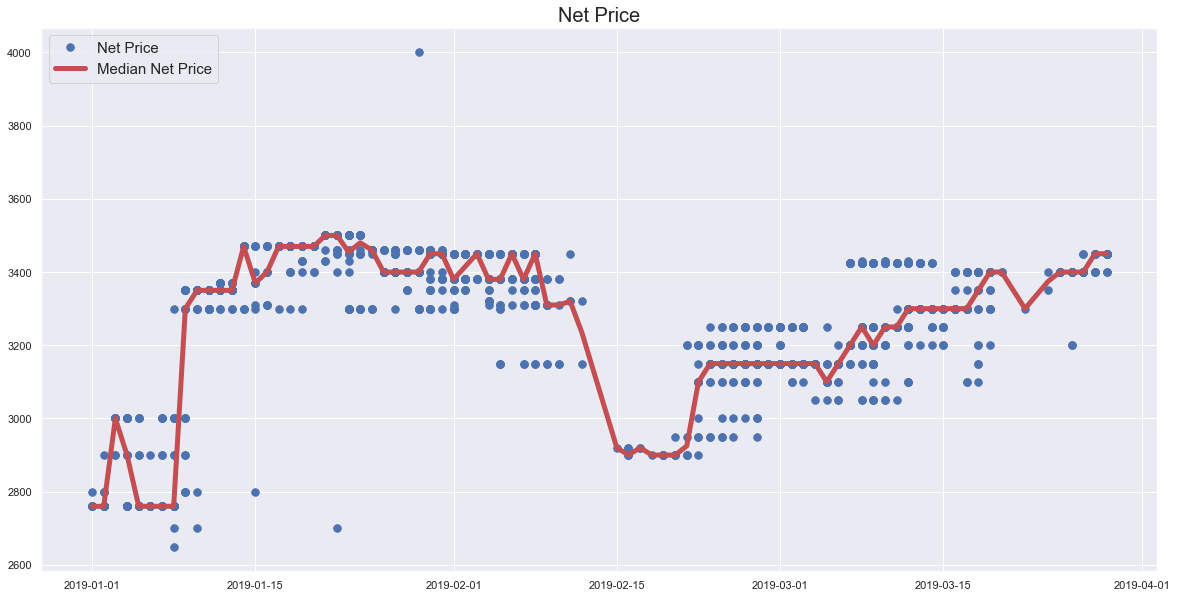

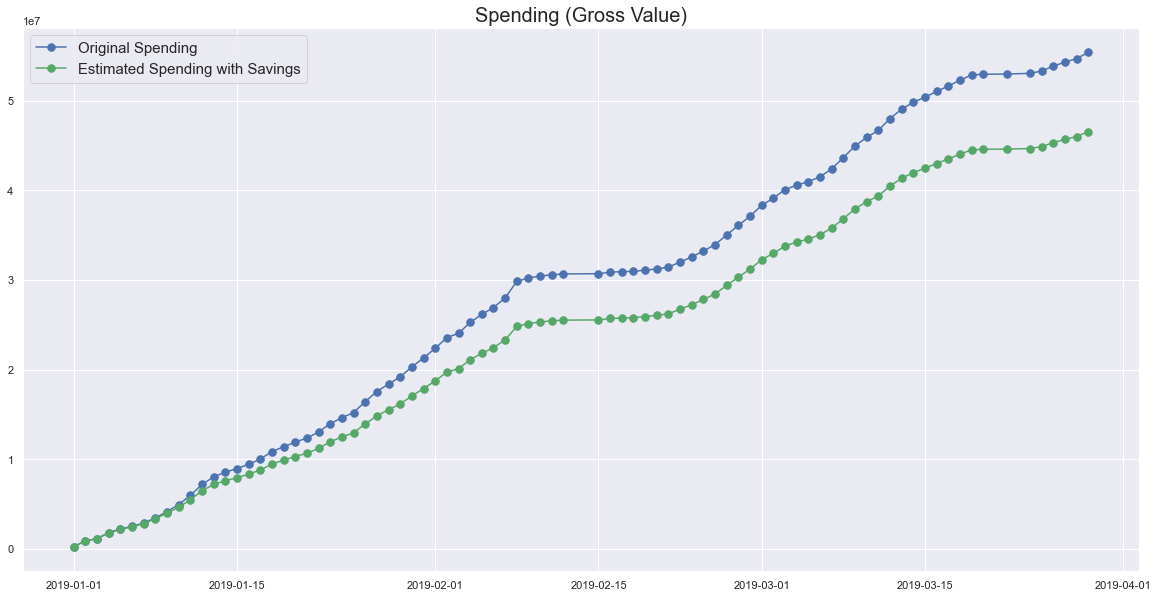

Local savings percentage (at the given drilled down level) at the end of the given period: 0.15956590908183774
Global savings percentage (at the given drilled down level) at the end of the given period: 0.0003684190595841459
-------------------------------------------------------------------------------------------------------------------





In [48]:
global_savings = 0

for (company_code, material, description) in df_selected.index:
    print(f'Company code: {company_code},  Material: {int(material)},  Description: {description}')
    
    # Select data with the right company code, material, and description
    indx_cocd = (data_1['CoCd'] == company_code).values
    indx_text = (data_1['Short Text'] == description).values
    indx_material = (data_1['Material'] == material).values
    indx = indx_cocd * indx_text * indx_material
    data_2 = data_1.loc[indx, :].copy()
    
    # Offset
    data_2['Offset'] = data_2['Gross value'] - data_2['Net Value']
    
    # The daily median net price calculated over all available net prices per day will be used:
    # 1) To indicate the "trend" of the net price in the given period
    # 2) As a reasonable (robust to outliers) estimate of the average daily net price
    data_3 = data_2.loc[:, ['Price Date', 'Net Price']].groupby('Price Date').median()['Net Price']
    
    # Generate savings using the following procedure: 
    # 1) Calculate spending (gross value) using a fixed median price from the first purchase day of the period
    #    as the price used in the whole period
    data_4 = data_2.copy()
    
    for price_date in data_3.index:
        indx = data_4['Price Date'] == price_date
        # New net price
        data_4.loc[indx, 'Net Price'] = data_3[0]
        # Recalculated net value
        data_4.loc[indx, 'Net Value'] = data_4.loc[indx, 'PO Quantity'] * data_4.loc[indx, 'Net Price']
        # Recalculated spending (gross value)
        data_4.loc[indx, 'Gross value'] = data_4.loc[indx, 'Net Value'] + data_4.loc[indx, 'Offset']
    
    # 2) Calculate savings resulting from the above substitution
    spend_original = data_2.groupby(['Price Date']).sum()['Gross value'].cumsum()
    spend_with_savings = data_4.groupby(['Price Date']).sum()['Gross value'].cumsum()
    savings = spend_original - spend_with_savings
    local_savings_percentage = (savings / spend_original)[-1]
    global_savings_percentage = savings[-1] / total_spending
    
    # 3) Check if at the end of the period we actually get any savings
    if savings[-1] > 0:
        global_savings += savings[-1]

        # Chart - net price
        plt.figure(figsize=(20, 10))
        plt.plot(
            data_2['Price Date'], data_2['Net Price'], 
            linestyle='', marker='.', markersize=15, label='Net Price'
        )
        plt.plot(data_3, linewidth=5, c='r', label='Median Net Price')
        plt.title('Net Price', fontsize = 20)
        plt.legend(fontsize=15, loc='upper left')
        plt.show()
        print()

        # Chart - cumulative spending with and without savings
        plt.figure(figsize=(20, 10))
        plt.plot(spend_original, marker='.', markersize=15, label='Original Spending')
        plt.plot(spend_with_savings, c='g', marker='.', markersize=15, label='Estimated Spending with Savings')
        plt.title('Spending (Gross Value)', fontsize = 20)
        plt.legend(fontsize=15, loc='upper left')
        plt.show()
        
        print(f'Local savings percentage (at the given drilled down level) at the end of the given period: {local_savings_percentage}')
        print(f'Global savings percentage (at the given drilled down level) at the end of the given period: {global_savings_percentage}')
        
    else:
        print('Our method does not generate any savings - a different approach is needed.')

    print('-------------------------------------------------------------------------------------------------------------------')
    print('\n\n')


Final savings estimate

In [58]:
print(f'Amount of savings: {np.round(global_savings, 2)}')
print(f'Savings as the percentage of total spending: {np.round(100 * (global_savings / total_spending), 3)}%')
print(f'Savings as the percentage of spending in 2019: {np.round(100 * (global_savings / spending_2019), 3)}%')

Amount of savings: 729763363.47
Savings as the percentage of total spending: 3.041%
Savings as the percentage of spending in 2019: 3.255%


Below, we verify that for the data selected above for saving opportunities the records with a missing storage location are negligible.

In [50]:
tmp_spending = 0
combined_indx = 0

for (company_code, material, description) in df_selected.index:
    #print(f'Company code: {company_code},  Material: {int(material)},  Description: {description}')
    
    # Select data with the right company code, material, and description
    indx_cocd = (data_1['CoCd'] == company_code).values
    indx_text = (data_1['Short Text'] == description).values
    indx_material = (data_1['Material'] == material).values
    indx = indx_cocd * indx_text * indx_material
    data_2 = data_1.loc[indx, :].copy()
    
    combined_indx += indx    
    tmp_spending += data_2.loc[data_2['SLoc'].isnull(), 'Gross value'].sum()

combined_indx = combined_indx > 0

pct_sloc_missing_spending = np.round(100 * tmp_spending/total_spending, 3)
print(f'Percentage of total spending for records with missing storage location: {pct_sloc_missing_spending}%')

Percentage of total spending for records with missing storage location: 0.111%


In [51]:
missing_data_percentage(data_1.loc[combined_indx, :])

NaN percentage threshold: 0%
Number of columns with more than 0% of missing values: 1

                             Mising Data %
Columns with missing values               
SLoc                                  0.04
